<a id='home'></a>
### purpose

Using a type II ANOVA, answer Q1: How do different evolutionary scenarios affect performance?

### outline

1. [load data](#data)

    - best case scenario data sets (all loci, all selective envs are known: ntraits=2).

1. [Estimate ANOVAs](#anova)

   1. [see the formulas used](#formulas)
   1. [output from super simple ANOVA](#ss_anova)
       - score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)
   1. [output from simple ANOVA](#simp_anova)
       - score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + final_LA  + C(garden)
   1. [output from combined architecture ANOVA](#comb_anova)
       - score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)
   1. [output from sanity check ANOVA](#sanity_anova)
       - sanity check looked for confounding between architecture (defined by 'combined' formula) and local adaptation. Because slevel was included in architecture, there is confounding between architecture and LA. The super simple model excludes slevel - [compare with simple formula results](#ss_anova_sos)
1. [look at figures for percent sum of squares of factors across methods](#sos)

   1. [super simple ANOVA](#ss_anova_sos)
   1. [simple ANOVA](#simp_anova_sos)
   1. [combined architecture ANOVA](#comb_anova_sos)
   1. [sanity check ANOVA](#sanity_anova_sos)
   
1. [visualize rank of sum of squares](#vis)

### Notes

- cor_TPR_\<env> = percentage of causal markers that were clinal

In [1]:
from pythonimports import *
from myfigs import slope_graph, adjust_box_widths, save_pdf

import MVP_summary_functions as mvp

import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import levene  # brown-forsythe test of equal variance

t1 = dt.now()  # notebook timer

summarydir = '/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_main_questions/01_Q1'
figdir = makedir(op.join(summarydir, 'figs'))
pkldir = '/work/lotterhos/MVP-Offsets/run_20220919/summaries/all_performance_dicts'

mvp.latest_commit()
session_info.show()

#########################################################
Today:	February 09, 2023 - 11:01:37
python version: 3.8.5

Current commit of pythonimports:
commit b5f64910f19a2f05c80319052d8d8ce5edc6765a  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Mon Jan 30 10:30:11 2023 -0500

Current commit of MVP_offsets:
commit caa0fefccc33fb9bba80c1589c9992c24b1ca836  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Thu Feb 9 10:32:41 2023 -0500
#########################################################



<a id='data'></a>
# 1. load data

[top](#home)

In [2]:
# # load validation scores organized by code in 00_save_level_scores.ipynb
# levelpkl = op.join(pkldir, 'level_scores.pkl')

# level_scores = pklload(levelpkl)

# programs = keys(level_scores)

# programs

In [3]:
# get bcs data
bcs = mvp.combine_level_dicts(use_bcs_data=True)  # bcs = mvp.get_bcs_data(level_scores)

programs = keys(bcs)
print(f'{programs = }')

# how many validation scores per seed (= num gardens)
for program, df in bcs.items():
    print(program, df.index.value_counts().unique())
    
# show preview of last dataframe
df.head()

reading reps (use_bcs_data = True): 100%|███████████████| 5/5 [00:08<00:00,  1.69s/it]


0-225
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


225-450
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


450-675
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


675-900
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180


900-1125
	 RONA num seeds =  180
	 lfmm2 num seeds =  180
	 GF num seeds =  180
	 rda num seeds =  180



 RONA df.shape = (180000, 22) num_seeds = 900 num_reps = 5

 lfmm2 df.shape = (90000, 23) num_seeds = 900 num_reps = 5

 GF df.shape = (90000, 22) num_seeds = 900 num_reps = 5

 rda df.shape = (90000, 24) num_seeds = 900 num_reps = 5
programs = ['RONA', 'lfmm2', 'GF', 'rda']
RONA [200]
lfmm2 [100]
GF [100]
rda [100]


,garden,score,glevel,plevel,pleio,slevel,landscape,popsize,migration,marker_set,seed,simulation_level,ntraits,structcrxn,noncausal_env,offset_level,architecture,plevel_pleio,demography,seed_garden,final_LA,cor_TPR_temp,cor_TPR_sal,rep,simulation_garden
1231109,1,-0.676768,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,all,1231109,highly-polygenic_2-trait_no-pleiotropy_equal-S...,ntraits-2,nocorr,all causal,highly-polygenic_2-trait_no-pleiotropy_equal-S...,highly-polygenic_2-trait_no-pleiotropy_equal-S,2-trait_no pleiotropy,N-cline-center-to-edge_m-constant,1_1231109,0.501332,0.495283,0.013652,0-225,highly-polygenic_2-trait_no-pleiotropy_equal-S...
1231109,2,-0.733609,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,all,1231109,highly-polygenic_2-trait_no-pleiotropy_equal-S...,ntraits-2,nocorr,all causal,highly-polygenic_2-trait_no-pleiotropy_equal-S...,highly-polygenic_2-trait_no-pleiotropy_equal-S,2-trait_no pleiotropy,N-cline-center-to-edge_m-constant,2_1231109,0.501332,0.495283,0.013652,0-225,highly-polygenic_2-trait_no-pleiotropy_equal-S...
1231109,3,-0.797172,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,all,1231109,highly-polygenic_2-trait_no-pleiotropy_equal-S...,ntraits-2,nocorr,all causal,highly-polygenic_2-trait_no-pleiotropy_equal-S...,highly-polygenic_2-trait_no-pleiotropy_equal-S,2-trait_no pleiotropy,N-cline-center-to-edge_m-constant,3_1231109,0.501332,0.495283,0.013652,0-225,highly-polygenic_2-trait_no-pleiotropy_equal-S...
1231109,4,-0.849293,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,all,1231109,highly-polygenic_2-trait_no-pleiotropy_equal-S...,ntraits-2,nocorr,all causal,highly-polygenic_2-trait_no-pleiotropy_equal-S...,highly-polygenic_2-trait_no-pleiotropy_equal-S,2-trait_no pleiotropy,N-cline-center-to-edge_m-constant,4_1231109,0.501332,0.495283,0.013652,0-225,highly-polygenic_2-trait_no-pleiotropy_equal-S...
1231109,5,-0.857143,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,all,1231109,highly-polygenic_2-trait_no-pleiotropy_equal-S...,ntraits-2,nocorr,all causal,highly-polygenic_2-trait_no-pleiotropy_equal-S...,highly-polygenic_2-trait_no-pleiotropy_equal-S,2-trait_no pleiotropy,N-cline-center-to-edge_m-constant,5_1231109,0.501332,0.495283,0.013652,0-225,highly-polygenic_2-trait_no-pleiotropy_equal-S...


<a id='anova'></a>
# 2. ANOVAs

[top](#home)

In [4]:
def print_summary_table(lm):
    """Do lm.summary2().__repr__() but just display the first table in lm.summary2().tables.
    
    summary - return from lm.summary2()
    """
    from statsmodels.iolib.summary2 import _simple_tables, _measure_tables

    summary = lm.summary2()
    
    tables = [summary.tables[0]]
    settings = [summary.settings[0]]
    pad_col, pad_index, widest = _measure_tables(tables, settings)
    rule_equal = widest * '='

    simple_tables = _simple_tables(tables, settings, pad_col, pad_index)
    tab = [x.as_text() for x in simple_tables]

    tab = '\n'.join(tab)
    tab = tab.split('\n')
    tab[0] = rule_equal
    tab.append(rule_equal)
    tab = '\n'.join(tab)
    
    print(tab)
    
    pass


def get_anova(formula_key):
    """Estimate ANOVA using evolutionary parameters as factors.
    
    Notes
    -----
    - displays statistical info from ANOVA and qqplot
    - C(factor) treats a numerical entry as a category (gardens are integer IDs)
    """
    # determine formula
    formula = formulas[formula_key]
    
    # get anovas
    lms = {}
    res = {}
    sos = []
    for program, df in bcs.items():
        print(f'\n{ColorText(program).green().bold()} {ColorText(formula_key).bold()} {ColorText(formula).blue()}')

        _df = df.copy()

        # add in level of LA + proportion of clines in temp + prop of clines in sal
        lms[program] = ols(formula, data=_df).fit()

        res[program] = anova_lm(lms[program], typ=2)
        
        # get percentages for sum of squares
        res[program]['perc_sum_sq'] = (
            (
                (res[program]['sum_sq'] / res[program]['sum_sq'].sum()) * 100
            ).round(2)
        )
        if round(abs(res[program]['perc_sum_sq'].sum() - 100), 2) > 0.02:  # account for compounding error rounding percs
            raise Exception('bad percentage', abs(res[program]['perc_sum_sq'].sum() - 100))

        res[program].index = res[program].index.map(mvp.factor_names)

        # brown-forsythe test?
        # TODO?

        # show more info
        display(res[program])
        print_summary_table(lms[program])

        sm.qqplot(lms[program].resid, line="45")
        plt.show()

        # get sum of squares
        sos.append(
            pd.Series(
                res[program]['sum_sq'].tolist(),
                name=program,
                index=res[program]['sum_sq'].index#.map(mvp.factor_names)
            )
        )
        
    return lms, res, sos

<a id='formulas'></a>
### formulas

[top](#home)

In [5]:
# FORMULA BUILDING
formulas = {
    'super_simple' : 'score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp ' \
                        '+ cor_TPR_sal + final_LA  + C(garden)',
    
    'simple' : 'score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp ' \
                        '+ slevel + cor_TPR_sal + final_LA  + C(garden)',
    
    'combined' : 'score ~ architecture + landscape + demography + cor_TPR_temp ' \
                        '+ cor_TPR_sal + final_LA  + C(garden)',
    
    'withLA_woArch' : 'score ~ landscape + demography + cor_TPR_temp ' \
                        '+ cor_TPR_sal + final_LA  + C(garden)',
    
    'woLA_withArch' : 'score ~ architecture + landscape + demography + cor_TPR_temp ' \
                        '+ cor_TPR_sal + C(garden)',
}

interactions = ' + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel'

# add interactions to formulas
for formula_key in keys(formulas):
    formula = formulas[formula_key]
    formulas[f'{formula_key}_interactions'] = formula + interactions


# set up blank dictionaries to fill in later
lms = {}  # linear models
res = {}  # anova output
sos = {}  # rank of factors

<a id='ss_anova'></a>
### super simple (excludes slevel)
[top](#home)


RONA super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,1.347323,2.0,12.797783,2.769421e-06,0.01
landscape,290.520234,2.0,2759.556596,0.000000e+00,2.43
demography,266.630925,4.0,1266.319935,0.000000e+00,2.23
pleiotropy,0.099418,1.0,1.888673,1.693533e-01,0.00
Garden ID,1251.323326,99.0,240.119407,0.000000e+00,10.45
"$\^p_{clinal, temp}$",2.122063,1.0,40.313557,2.168158e-10,0.02
"$\^p_{clinal, Env2}$",1.979454,1.0,37.604362,8.682988e-10,0.02
Degree of\nlocal adaptation,689.755714,1.0,13103.527462,0.000000e+00,5.76
Residual,9469.112520,179888.0,NaN,NaN,79.09


Model:              OLS              Adj. R-squared:     0.232      
Dependent Variable: score            AIC:                -19044.0274
Date:               2023-02-09 11:01 BIC:                -17912.7476
No. Observations:   180000           Log-Likelihood:     9634.0     
Df Model:           111              F-statistic:        490.7      
Df Residuals:       179888           Prob (F-statistic): 0.00       
R-squared:          0.232            Scale:              0.052639   


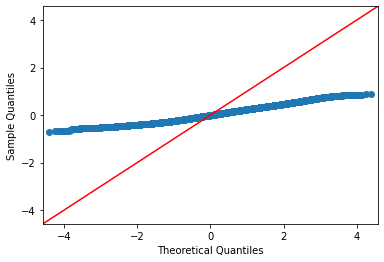


lfmm2 super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.294735,2.0,11.658369,8.659468e-06,0.01
landscape,77.105963,2.0,3049.954378,0.000000e+00,2.82
demography,133.666632,4.0,2643.616093,0.000000e+00,4.90
pleiotropy,0.088065,1.0,6.966883,8.304634e-03,0.00
Garden ID,196.230674,99.0,156.807587,0.000000e+00,7.19
"$\^p_{clinal, temp}$",0.665576,1.0,52.654193,4.009550e-13,0.02
"$\^p_{clinal, Env2}$",0.318001,1.0,25.157292,5.293984e-07,0.01
Degree of\nlocal adaptation,1185.276223,1.0,93768.063047,0.000000e+00,43.42
Residual,1136.230244,89888.0,NaN,NaN,41.62


Model:              OLS              Adj. R-squared:     0.661       
Dependent Variable: score            AIC:                -137855.4962
Date:               2023-02-09 11:01 BIC:                -136801.8489
No. Observations:   90000            Log-Likelihood:     69040.      
Df Model:           111              F-statistic:        1583.       
Df Residuals:       89888            Prob (F-statistic): 0.00        
R-squared:          0.662            Scale:              0.012641    


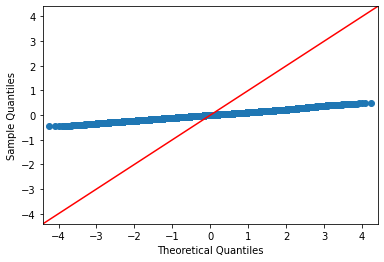


GF super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.315325,2.0,15.112480,2.740541e-07,0.01
landscape,701.766144,2.0,33633.314959,0.000000e+00,17.95
demography,149.077742,4.0,3572.399919,0.000000e+00,3.81
pleiotropy,0.344916,1.0,33.061398,8.958214e-09,0.01
Garden ID,196.970828,99.0,190.710222,0.000000e+00,5.04
"$\^p_{clinal, temp}$",2.270133,1.0,217.599830,3.447934e-49,0.06
"$\^p_{clinal, Env2}$",1.988792,1.0,190.632379,2.562061e-43,0.05
Degree of\nlocal adaptation,1918.311770,1.0,183876.593258,0.000000e+00,49.08
Residual,937.765951,89888.0,NaN,NaN,23.99


Model:              OLS              Adj. R-squared:     0.807       
Dependent Variable: score            AIC:                -155132.8736
Date:               2023-02-09 11:01 BIC:                -154079.2263
No. Observations:   90000            Log-Likelihood:     77678.      
Df Model:           111              F-statistic:        3391.       
Df Residuals:       89888            Prob (F-statistic): 0.00        
R-squared:          0.807            Scale:              0.010433    


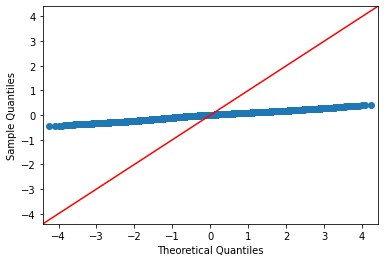


rda super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.347947,2.0,13.729497,1.092109e-06,0.01
landscape,685.857334,2.0,27062.966082,0.000000e+00,17.09
demography,145.077268,4.0,2862.272503,0.000000e+00,3.62
pleiotropy,0.023863,1.0,1.883185,1.699760e-01,0.00
Garden ID,190.119174,99.0,151.552228,0.000000e+00,4.74
"$\^p_{clinal, temp}$",3.974285,1.0,313.639384,4.631503e-70,0.10
"$\^p_{clinal, Env2}$",2.716066,1.0,214.344271,1.762122e-48,0.07
Degree of\nlocal adaptation,1845.919289,1.0,145674.759473,0.000000e+00,46.00
Residual,1139.016764,89888.0,NaN,NaN,28.38


Model:              OLS              Adj. R-squared:     0.784       
Dependent Variable: score            AIC:                -137635.0482
Date:               2023-02-09 11:01 BIC:                -136581.4009
No. Observations:   90000            Log-Likelihood:     68930.      
Df Model:           111              F-statistic:        2945.       
Df Residuals:       89888            Prob (F-statistic): 0.00        
R-squared:          0.784            Scale:              0.012672    


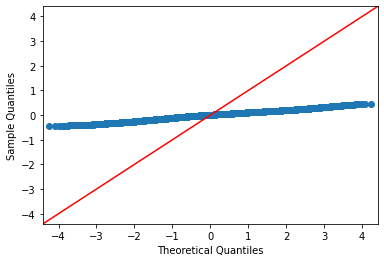

In [6]:
formula_key = 'super_simple'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)


RONA super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,1.347323,2.0,12.797783,2.769421e-06,0.01
landscape,290.520234,2.0,2759.556596,0.000000e+00,2.43
demography,266.630925,4.0,1266.319935,0.000000e+00,2.23
pleiotropy,0.099418,1.0,1.888673,1.693533e-01,0.00
Garden ID,1251.323326,99.0,240.119407,0.000000e+00,10.45
"$\^p_{clinal, temp}$",2.122063,1.0,40.313557,2.168158e-10,0.02
"$\^p_{clinal, Env2}$",1.979454,1.0,37.604362,8.682988e-10,0.02
Degree of\nlocal adaptation,689.755714,1.0,13103.527462,0.000000e+00,5.76
Residual,9469.112520,179888.0,NaN,NaN,79.09


Model:              OLS              Adj. R-squared:     0.232      
Dependent Variable: score            AIC:                -19044.0274
Date:               2023-02-09 11:02 BIC:                -17912.7476
No. Observations:   180000           Log-Likelihood:     9634.0     
Df Model:           111              F-statistic:        490.7      
Df Residuals:       179888           Prob (F-statistic): 0.00       
R-squared:          0.232            Scale:              0.052639   


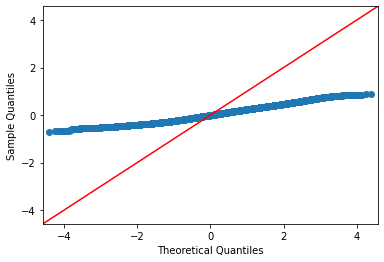


lfmm2 super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.294735,2.0,11.658369,8.659468e-06,0.01
landscape,77.105963,2.0,3049.954378,0.000000e+00,2.82
demography,133.666632,4.0,2643.616093,0.000000e+00,4.90
pleiotropy,0.088065,1.0,6.966883,8.304634e-03,0.00
Garden ID,196.230674,99.0,156.807587,0.000000e+00,7.19
"$\^p_{clinal, temp}$",0.665576,1.0,52.654193,4.009550e-13,0.02
"$\^p_{clinal, Env2}$",0.318001,1.0,25.157292,5.293984e-07,0.01
Degree of\nlocal adaptation,1185.276223,1.0,93768.063047,0.000000e+00,43.42
Residual,1136.230244,89888.0,NaN,NaN,41.62


Model:              OLS              Adj. R-squared:     0.661       
Dependent Variable: score            AIC:                -137855.4962
Date:               2023-02-09 11:02 BIC:                -136801.8489
No. Observations:   90000            Log-Likelihood:     69040.      
Df Model:           111              F-statistic:        1583.       
Df Residuals:       89888            Prob (F-statistic): 0.00        
R-squared:          0.662            Scale:              0.012641    


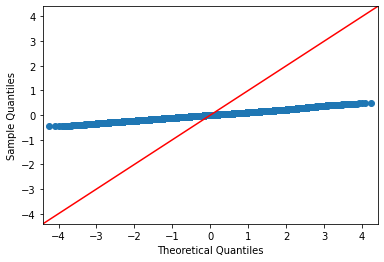


GF super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.315325,2.0,15.112480,2.740541e-07,0.01
landscape,701.766144,2.0,33633.314959,0.000000e+00,17.95
demography,149.077742,4.0,3572.399919,0.000000e+00,3.81
pleiotropy,0.344916,1.0,33.061398,8.958214e-09,0.01
Garden ID,196.970828,99.0,190.710222,0.000000e+00,5.04
"$\^p_{clinal, temp}$",2.270133,1.0,217.599830,3.447934e-49,0.06
"$\^p_{clinal, Env2}$",1.988792,1.0,190.632379,2.562061e-43,0.05
Degree of\nlocal adaptation,1918.311770,1.0,183876.593258,0.000000e+00,49.08
Residual,937.765951,89888.0,NaN,NaN,23.99


Model:              OLS              Adj. R-squared:     0.807       
Dependent Variable: score            AIC:                -155132.8736
Date:               2023-02-09 11:02 BIC:                -154079.2263
No. Observations:   90000            Log-Likelihood:     77678.      
Df Model:           111              F-statistic:        3391.       
Df Residuals:       89888            Prob (F-statistic): 0.00        
R-squared:          0.807            Scale:              0.010433    


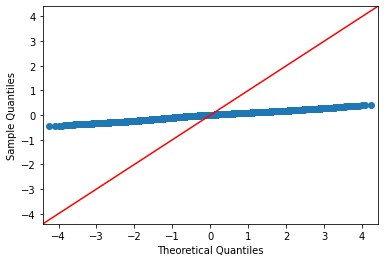


rda super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.347947,2.0,13.729497,1.092109e-06,0.01
landscape,685.857334,2.0,27062.966082,0.000000e+00,17.09
demography,145.077268,4.0,2862.272503,0.000000e+00,3.62
pleiotropy,0.023863,1.0,1.883185,1.699760e-01,0.00
Garden ID,190.119174,99.0,151.552228,0.000000e+00,4.74
"$\^p_{clinal, temp}$",3.974285,1.0,313.639384,4.631503e-70,0.10
"$\^p_{clinal, Env2}$",2.716066,1.0,214.344271,1.762122e-48,0.07
Degree of\nlocal adaptation,1845.919289,1.0,145674.759473,0.000000e+00,46.00
Residual,1139.016764,89888.0,NaN,NaN,28.38


Model:              OLS              Adj. R-squared:     0.784       
Dependent Variable: score            AIC:                -137635.0482
Date:               2023-02-09 11:02 BIC:                -136581.4009
No. Observations:   90000            Log-Likelihood:     68930.      
Df Model:           111              F-statistic:        2945.       
Df Residuals:       89888            Prob (F-statistic): 0.00        
R-squared:          0.784            Scale:              0.012672    


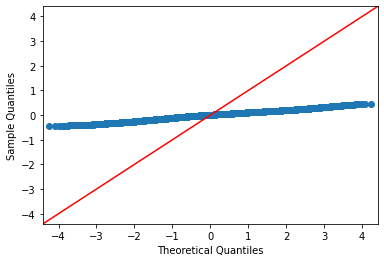

In [7]:
formula_key = 'super_simple'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)


RONA super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,1.347323,2.0,12.797783,2.769421e-06,0.01
landscape,290.520234,2.0,2759.556596,0.000000e+00,2.43
demography,266.630925,4.0,1266.319935,0.000000e+00,2.23
pleiotropy,0.099418,1.0,1.888673,1.693533e-01,0.00
Garden ID,1251.323326,99.0,240.119407,0.000000e+00,10.45
"$\^p_{clinal, temp}$",2.122063,1.0,40.313557,2.168158e-10,0.02
"$\^p_{clinal, Env2}$",1.979454,1.0,37.604362,8.682988e-10,0.02
Degree of\nlocal adaptation,689.755714,1.0,13103.527462,0.000000e+00,5.76
Residual,9469.112520,179888.0,NaN,NaN,79.09


Model:              OLS              Adj. R-squared:     0.232      
Dependent Variable: score            AIC:                -19044.0274
Date:               2023-02-09 11:02 BIC:                -17912.7476
No. Observations:   180000           Log-Likelihood:     9634.0     
Df Model:           111              F-statistic:        490.7      
Df Residuals:       179888           Prob (F-statistic): 0.00       
R-squared:          0.232            Scale:              0.052639   


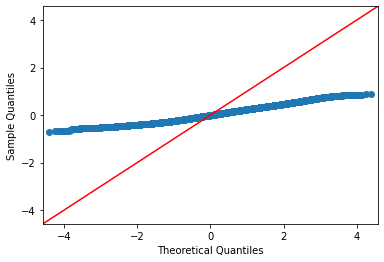


lfmm2 super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.294735,2.0,11.658369,8.659468e-06,0.01
landscape,77.105963,2.0,3049.954378,0.000000e+00,2.82
demography,133.666632,4.0,2643.616093,0.000000e+00,4.90
pleiotropy,0.088065,1.0,6.966883,8.304634e-03,0.00
Garden ID,196.230674,99.0,156.807587,0.000000e+00,7.19
"$\^p_{clinal, temp}$",0.665576,1.0,52.654193,4.009550e-13,0.02
"$\^p_{clinal, Env2}$",0.318001,1.0,25.157292,5.293984e-07,0.01
Degree of\nlocal adaptation,1185.276223,1.0,93768.063047,0.000000e+00,43.42
Residual,1136.230244,89888.0,NaN,NaN,41.62


Model:              OLS              Adj. R-squared:     0.661       
Dependent Variable: score            AIC:                -137855.4962
Date:               2023-02-09 11:02 BIC:                -136801.8489
No. Observations:   90000            Log-Likelihood:     69040.      
Df Model:           111              F-statistic:        1583.       
Df Residuals:       89888            Prob (F-statistic): 0.00        
R-squared:          0.662            Scale:              0.012641    


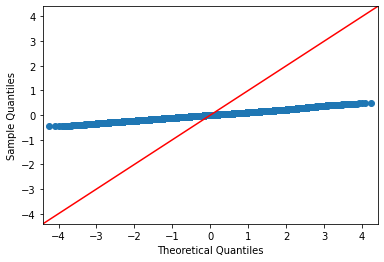


GF super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.315325,2.0,15.112480,2.740541e-07,0.01
landscape,701.766144,2.0,33633.314959,0.000000e+00,17.95
demography,149.077742,4.0,3572.399919,0.000000e+00,3.81
pleiotropy,0.344916,1.0,33.061398,8.958214e-09,0.01
Garden ID,196.970828,99.0,190.710222,0.000000e+00,5.04
"$\^p_{clinal, temp}$",2.270133,1.0,217.599830,3.447934e-49,0.06
"$\^p_{clinal, Env2}$",1.988792,1.0,190.632379,2.562061e-43,0.05
Degree of\nlocal adaptation,1918.311770,1.0,183876.593258,0.000000e+00,49.08
Residual,937.765951,89888.0,NaN,NaN,23.99


Model:              OLS              Adj. R-squared:     0.807       
Dependent Variable: score            AIC:                -155132.8736
Date:               2023-02-09 11:02 BIC:                -154079.2263
No. Observations:   90000            Log-Likelihood:     77678.      
Df Model:           111              F-statistic:        3391.       
Df Residuals:       89888            Prob (F-statistic): 0.00        
R-squared:          0.807            Scale:              0.010433    


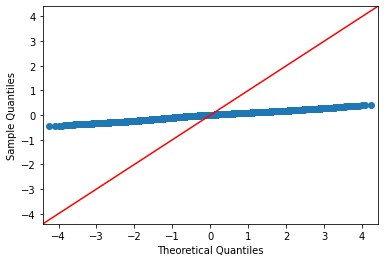


rda super_simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.347947,2.0,13.729497,1.092109e-06,0.01
landscape,685.857334,2.0,27062.966082,0.000000e+00,17.09
demography,145.077268,4.0,2862.272503,0.000000e+00,3.62
pleiotropy,0.023863,1.0,1.883185,1.699760e-01,0.00
Garden ID,190.119174,99.0,151.552228,0.000000e+00,4.74
"$\^p_{clinal, temp}$",3.974285,1.0,313.639384,4.631503e-70,0.10
"$\^p_{clinal, Env2}$",2.716066,1.0,214.344271,1.762122e-48,0.07
Degree of\nlocal adaptation,1845.919289,1.0,145674.759473,0.000000e+00,46.00
Residual,1139.016764,89888.0,NaN,NaN,28.38


Model:              OLS              Adj. R-squared:     0.784       
Dependent Variable: score            AIC:                -137635.0482
Date:               2023-02-09 11:02 BIC:                -136581.4009
No. Observations:   90000            Log-Likelihood:     68930.      
Df Model:           111              F-statistic:        2945.       
Df Residuals:       89888            Prob (F-statistic): 0.00        
R-squared:          0.784            Scale:              0.012672    


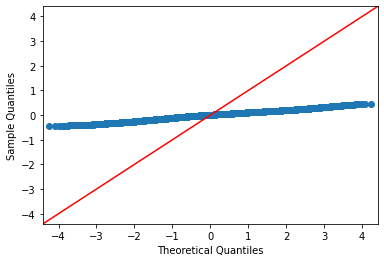

In [8]:
formula_key = 'super_simple'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)


RONA super_simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,2.102148,2.0,20.984753,7.717938e-10,0.02
landscape,261.148605,2.0,2606.923743,0.000000e+00,2.20
demography,211.737919,4.0,1056.840050,0.000000e+00,1.78
pleiotropy,0.264277,1.0,5.276305,2.161872e-02,0.00
Garden ID,1251.323326,99.0,252.350959,0.000000e+00,10.54
"$\^p_{clinal, temp}$",0.763040,1.0,15.234141,9.500549e-05,0.01
"$\^p_{clinal, Env2}$",0.137694,1.0,2.749064,9.731315e-02,0.00
Degree of\nlocal adaptation,689.755714,1.0,13771.014016,0.000000e+00,5.81
final_LA:architecture,4.288541,11.0,7.783724,1.205842e-13,0.04
final_LA:landscape,46.487746,2.0,464.065313,9.494235e-202,0.39


Model:              OLS              Adj. R-squared:     0.269      
Dependent Variable: score            AIC:                -27875.3391
Date:               2023-02-09 11:02 BIC:                -25612.7796
No. Observations:   180000           Log-Likelihood:     14162.     
Df Model:           223              F-statistic:        298.3      
Df Residuals:       179776           Prob (F-statistic): 0.00       
R-squared:          0.270            Scale:              0.050088   


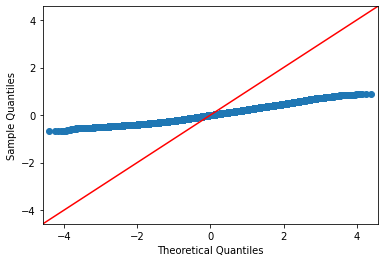


lfmm2 super_simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.102668,2.0,4.894509,7.489580e-03,0.00
landscape,67.133027,2.0,3200.448534,0.000000e+00,2.44
demography,146.130006,4.0,3483.245014,0.000000e+00,5.32
pleiotropy,0.438586,1.0,41.817612,1.007090e-10,0.02
Garden ID,196.230674,99.0,188.988907,0.000000e+00,7.14
"$\^p_{clinal, temp}$",0.045702,1.0,4.357490,3.684936e-02,0.00
"$\^p_{clinal, Env2}$",0.000163,1.0,0.015541,9.007916e-01,0.00
Degree of\nlocal adaptation,1185.276223,1.0,113011.902229,0.000000e+00,43.13
final_LA:architecture,19.146993,11.0,165.963474,0.000000e+00,0.70
final_LA:landscape,112.994770,2.0,5386.826132,0.000000e+00,4.11


Model:              OLS              Adj. R-squared:     0.719       
Dependent Variable: score            AIC:                -154543.8998
Date:               2023-02-09 11:02 BIC:                -152436.6053
No. Observations:   90000            Log-Likelihood:     77496.      
Df Model:           223              F-statistic:        1033.       
Df Residuals:       89776            Prob (F-statistic): 0.00        
R-squared:          0.720            Scale:              0.010488    


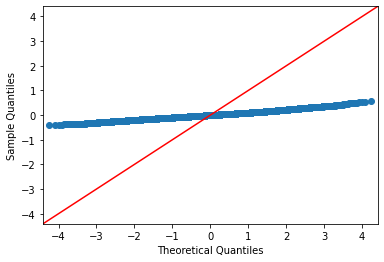


GF super_simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.599082,2.0,32.591983,7.089535e-15,0.02
landscape,530.677599,2.0,28870.564855,0.000000e+00,14.23
demography,121.192578,4.0,3296.632636,0.000000e+00,3.25
pleiotropy,0.426594,1.0,46.416175,9.622274e-12,0.01
Garden ID,196.970828,99.0,216.481723,0.000000e+00,5.28
"$\^p_{clinal, temp}$",1.178685,1.0,128.248507,1.037440e-29,0.03
"$\^p_{clinal, Env2}$",0.430533,1.0,46.844775,7.732848e-12,0.01
Degree of\nlocal adaptation,1918.311770,1.0,208724.636008,0.000000e+00,51.45
final_LA:architecture,21.211683,11.0,209.815207,0.000000e+00,0.57
final_LA:landscape,58.936203,2.0,3206.318605,0.000000e+00,1.58


Model:              OLS              Adj. R-squared:     0.830       
Dependent Variable: score            AIC:                -166428.6738
Date:               2023-02-09 11:02 BIC:                -164321.3793
No. Observations:   90000            Log-Likelihood:     83438.      
Df Model:           223              F-statistic:        1971.       
Df Residuals:       89776            Prob (F-statistic): 0.00        
R-squared:          0.830            Scale:              0.0091906   


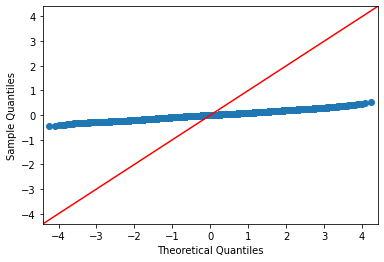


rda super_simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,1.159134,2.0,52.477349,1.669892e-23,0.03
landscape,551.115124,2.0,24950.581573,0.000000e+00,14.20
demography,132.719875,4.0,3004.307017,0.000000e+00,3.42
pleiotropy,0.566356,1.0,51.281190,8.064977e-13,0.01
Garden ID,190.119174,99.0,173.883777,0.000000e+00,4.90
"$\^p_{clinal, temp}$",2.790267,1.0,252.646967,8.223353e-57,0.07
"$\^p_{clinal, Env2}$",0.398597,1.0,36.091286,1.890085e-09,0.01
Degree of\nlocal adaptation,1845.919289,1.0,167140.250078,0.000000e+00,47.56
final_LA:architecture,23.964690,11.0,197.263836,0.000000e+00,0.62
final_LA:landscape,88.172822,2.0,3991.839613,0.000000e+00,2.27


Model:              OLS              Adj. R-squared:     0.812       
Dependent Variable: score            AIC:                -149894.3713
Date:               2023-02-09 11:02 BIC:                -147787.0768
No. Observations:   90000            Log-Likelihood:     75171.      
Df Model:           223              F-statistic:        1742.       
Df Residuals:       89776            Prob (F-statistic): 0.00        
R-squared:          0.812            Scale:              0.011044    


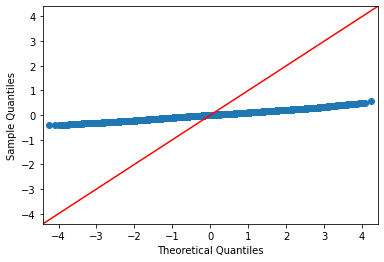

In [9]:
formula_key = 'super_simple_interactions'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)

<a id='simp_anova'></a>
### simple factors
[top](#home)


RONA simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.586209,2.0,5.568581,3.816551e-03,0.01
landscape,236.490754,2.0,2246.499490,0.000000e+00,2.11
demography,217.491787,4.0,1033.011189,0.000000e+00,1.94
pleiotropy,0.229118,1.0,4.352929,3.694676e-02,0.00
slevel,0.690109,1.0,13.111123,2.936282e-04,0.01
Garden ID,1251.323326,99.0,240.135573,0.000000e+00,11.17
"$\^p_{clinal, temp}$",2.017523,1.0,38.330161,5.986063e-10,0.02
"$\^p_{clinal, Env2}$",1.803439,1.0,34.262858,4.823153e-09,0.02
Degree of\nlocal adaptation,26.994177,1.0,512.852227,2.191391e-113,0.24
Residual,9468.422411,179887.0,NaN,NaN,84.49


Model:              OLS              Adj. R-squared:     0.232      
Dependent Variable: score            AIC:                -19055.1463
Date:               2023-02-09 11:02 BIC:                -17913.7658
No. Observations:   180000           Log-Likelihood:     9640.6     
Df Model:           112              F-statistic:        486.5      
Df Residuals:       179887           Prob (F-statistic): 0.00       
R-squared:          0.232            Scale:              0.052635   


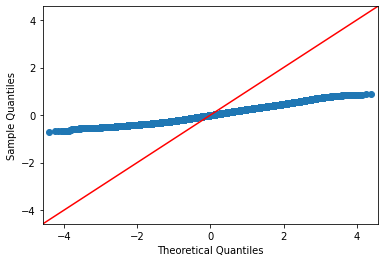


lfmm2 simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.394719,2.0,15.677886,1.557284e-07,0.03
landscape,66.690472,2.0,2648.885401,0.000000e+00,4.30
demography,138.362846,4.0,2747.823724,0.000000e+00,8.91
pleiotropy,0.023437,1.0,1.861815,1.724189e-01,0.00
slevel,4.696493,1.0,373.080927,5.887734e-83,0.30
Garden ID,196.230674,99.0,157.456674,0.000000e+00,12.64
"$\^p_{clinal, temp}$",0.821757,1.0,65.278866,6.581334e-16,0.05
"$\^p_{clinal, Env2}$",0.518009,1.0,41.149690,1.417031e-10,0.03
Degree of\nlocal adaptation,12.961370,1.0,1029.627879,1.223566e-224,0.84
Residual,1131.533751,89887.0,NaN,NaN,72.90


Model:              OLS              Adj. R-squared:     0.663       
Dependent Variable: score            AIC:                -138226.2731
Date:               2023-02-09 11:02 BIC:                -137163.2182
No. Observations:   90000            Log-Likelihood:     69226.      
Df Model:           112              F-statistic:        1579.       
Df Residuals:       89887            Prob (F-statistic): 0.00        
R-squared:          0.663            Scale:              0.012588    


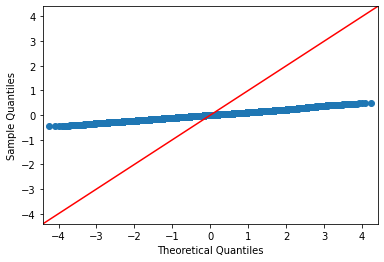


GF simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.719265,2.0,34.827909,7.590826e-16,0.04
landscape,558.955831,2.0,27065.509131,0.000000e+00,30.32
demography,125.966099,4.0,3049.737027,0.000000e+00,6.83
pleiotropy,0.003497,1.0,0.338614,5.606319e-01,0.00
slevel,9.594555,1.0,929.166456,4.891340e-203,0.52
Garden ID,196.970828,99.0,192.679460,0.000000e+00,10.68
"$\^p_{clinal, temp}$",2.676502,1.0,259.200789,3.092763e-58,0.15
"$\^p_{clinal, Env2}$",2.661321,1.0,257.730603,6.455062e-58,0.14
Degree of\nlocal adaptation,18.014555,1.0,1744.585480,0.000000e+00,0.98
Residual,928.171396,89887.0,NaN,NaN,50.34


Model:              OLS              Adj. R-squared:     0.809       
Dependent Variable: score            AIC:                -156056.4325
Date:               2023-02-09 11:02 BIC:                -154993.3777
No. Observations:   90000            Log-Likelihood:     78141.      
Df Model:           112              F-statistic:        3404.       
Df Residuals:       89887            Prob (F-statistic): 0.00        
R-squared:          0.809            Scale:              0.010326    


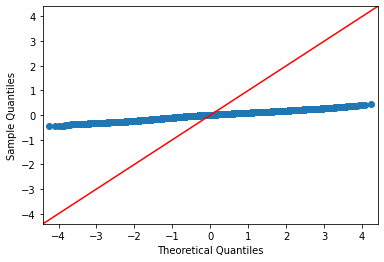


rda simple score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.448838,2.0,17.853794,1.769030e-08,0.02
landscape,591.145549,2.0,23514.488894,0.000000e+00,28.42
demography,133.837662,4.0,2661.886077,0.000000e+00,6.43
pleiotropy,0.219076,1.0,17.428701,2.985683e-05,0.01
slevel,9.153805,1.0,728.237081,9.428181e-160,0.44
Garden ID,190.119174,99.0,152.778359,0.000000e+00,9.14
"$\^p_{clinal, temp}$",4.491845,1.0,357.351747,1.516841e-79,0.22
"$\^p_{clinal, Env2}$",3.471914,1.0,276.210415,6.223885e-62,0.17
Degree of\nlocal adaptation,17.441416,1.0,1387.563440,2.138870e-301,0.84
Residual,1129.862958,89887.0,NaN,NaN,54.32


Model:              OLS              Adj. R-squared:     0.786       
Dependent Variable: score            AIC:                -138359.2629
Date:               2023-02-09 11:02 BIC:                -137296.2081
No. Observations:   90000            Log-Likelihood:     69293.      
Df Model:           112              F-statistic:        2949.       
Df Residuals:       89887            Prob (F-statistic): 0.00        
R-squared:          0.786            Scale:              0.012570    


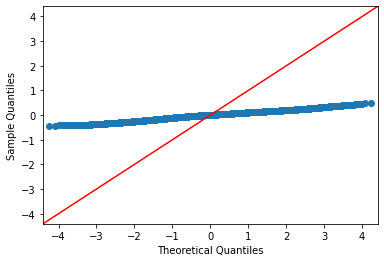

In [10]:
formula_key = 'simple'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)


RONA simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,3.420607,2.0,34.170210,1.455078e-15,0.03
landscape,222.469865,2.0,2222.366347,0.000000e+00,1.99
demography,216.666593,4.0,1082.197232,0.000000e+00,1.94
pleiotropy,0.056790,1.0,1.134616,2.867944e-01,0.00
slevel,0.061476,1.0,1.228223,2.677545e-01,0.00
Garden ID,1251.323326,99.0,252.527572,0.000000e+00,11.22
"$\^p_{clinal, temp}$",0.792361,1.0,15.830615,6.929970e-05,0.01
"$\^p_{clinal, Env2}$",0.201098,1.0,4.017736,4.502561e-02,0.00
Degree of\nlocal adaptation,26.994177,1.0,539.317544,3.979819e-119,0.24
final_LA:architecture,10.457017,11.0,18.992825,1.103711e-38,0.09


Model:              OLS              Adj. R-squared:     0.270      
Dependent Variable: score            AIC:                -28000.2729
Date:               2023-02-09 11:02 BIC:                -25727.6127
No. Observations:   180000           Log-Likelihood:     14225.     
Df Model:           224              F-statistic:        297.7      
Df Residuals:       179775           Prob (F-statistic): 0.00       
R-squared:          0.271            Scale:              0.050052   


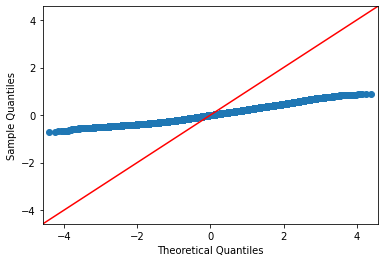


lfmm2 simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.070850,2.0,3.382251,3.397522e-02,0.00
landscape,68.357528,2.0,3263.242664,0.000000e+00,4.62
demography,147.251449,4.0,3514.735154,0.000000e+00,9.94
pleiotropy,0.286902,1.0,27.392192,1.664729e-07,0.02
slevel,8.663552,1.0,827.159028,4.484601e-181,0.59
Garden ID,196.230674,99.0,189.245133,0.000000e+00,13.25
"$\^p_{clinal, temp}$",0.048958,1.0,4.674296,3.061988e-02,0.00
"$\^p_{clinal, Env2}$",0.000490,1.0,0.046770,8.287827e-01,0.00
Degree of\nlocal adaptation,12.961370,1.0,1237.496388,2.982530e-269,0.88
final_LA:architecture,2.012447,11.0,17.467262,3.477563e-35,0.14


Model:              OLS              Adj. R-squared:     0.719       
Dependent Variable: score            AIC:                -154664.8395
Date:               2023-02-09 11:02 BIC:                -152548.1374
No. Observations:   90000            Log-Likelihood:     77557.      
Df Model:           224              F-statistic:        1030.       
Df Residuals:       89775            Prob (F-statistic): 0.00        
R-squared:          0.720            Scale:              0.010474    


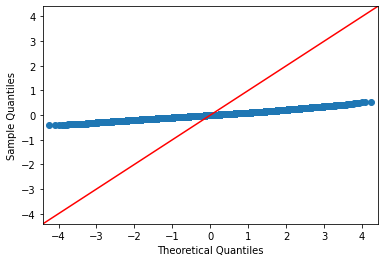


GF simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,0.834582,2.0,45.510346,1.758411e-20,0.05
landscape,506.103250,2.0,27598.173948,0.000000e+00,29.10
demography,120.230497,4.0,3278.127716,0.000000e+00,6.91
pleiotropy,0.248578,1.0,27.110311,1.925925e-07,0.01
slevel,7.525339,1.0,820.724334,1.091362e-179,0.43
Garden ID,196.970828,99.0,216.989107,0.000000e+00,11.32
"$\^p_{clinal, temp}$",1.198690,1.0,130.730822,2.975890e-30,0.07
"$\^p_{clinal, Env2}$",0.488170,1.0,53.240512,2.975346e-13,0.03
Degree of\nlocal adaptation,18.014555,1.0,1964.693305,0.000000e+00,1.04
final_LA:architecture,3.544535,11.0,35.142914,6.428397e-76,0.20


Model:              OLS              Adj. R-squared:     0.830       
Dependent Variable: score            AIC:                -166638.3689
Date:               2023-02-09 11:02 BIC:                -164521.6668
No. Observations:   90000            Log-Likelihood:     83544.      
Df Model:           224              F-statistic:        1968.       
Df Residuals:       89775            Prob (F-statistic): 0.00        
R-squared:          0.831            Scale:              0.0091691   


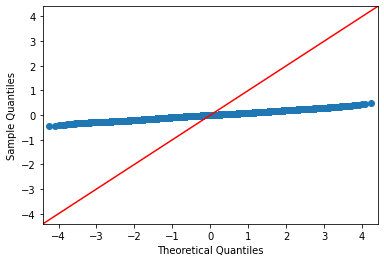


rda simple_interactions score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
genic level,1.281331,2.0,58.117718,5.972025e-26,0.07
landscape,540.402185,2.0,24511.192036,0.000000e+00,27.44
demography,132.227496,4.0,2998.742087,0.000000e+00,6.71
pleiotropy,0.360779,1.0,32.727961,1.063371e-08,0.02
slevel,5.979965,1.0,542.470299,1.241081e-119,0.30
Garden ID,190.119174,99.0,174.207985,0.000000e+00,9.65
"$\^p_{clinal, temp}$",2.820295,1.0,255.842028,1.661539e-57,0.14
"$\^p_{clinal, Env2}$",0.452901,1.0,41.084780,1.464868e-10,0.02
Degree of\nlocal adaptation,17.441416,1.0,1582.191564,0.000000e+00,0.89
final_LA:architecture,8.406463,11.0,69.326291,9.789592e-156,0.43


Model:              OLS              Adj. R-squared:     0.812       
Dependent Variable: score            AIC:                -150061.0234
Date:               2023-02-09 11:03 BIC:                -147944.3213
No. Observations:   90000            Log-Likelihood:     75256.      
Df Model:           224              F-statistic:        1738.       
Df Residuals:       89775            Prob (F-statistic): 0.00        
R-squared:          0.813            Scale:              0.011024    


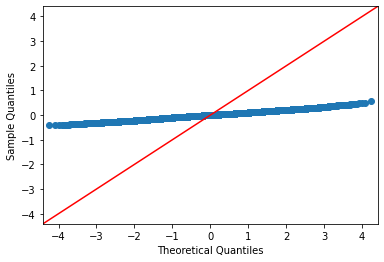

In [11]:
formula_key = 'simple_interactions'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)

<a id='comb_anova'></a>
### combined factors
[top](#home)


RONA combined score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
architecture,5.336690,11.0,9.220095,9.449994e-17,0.05
landscape,228.964620,2.0,2175.677411,0.000000e+00,2.04
demography,212.936608,4.0,1011.687672,0.000000e+00,1.90
Garden ID,1251.323326,99.0,240.209658,0.000000e+00,11.18
"$\^p_{clinal, temp}$",1.015055,1.0,19.290593,1.123220e-05,0.01
"$\^p_{clinal, Env2}$",2.484068,1.0,47.208442,6.403125e-12,0.02
Degree of\nlocal adaptation,29.352883,1.0,557.836450,3.831561e-123,0.26
Residual,9465.133867,179880.0,NaN,NaN,84.54


Model:              OLS              Adj. R-squared:     0.232      
Dependent Variable: score            AIC:                -19103.6742
Date:               2023-02-09 11:03 BIC:                -17891.5887
No. Observations:   180000           Log-Likelihood:     9671.8     
Df Model:           119              F-statistic:        458.5      
Df Residuals:       179880           Prob (F-statistic): 0.00       
R-squared:          0.233            Scale:              0.052619   


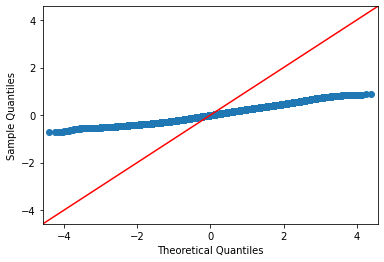


lfmm2 combined score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
architecture,7.962275,11.0,57.641762,2.127129e-128,0.51
landscape,62.066516,2.0,2471.269503,0.000000e+00,4.01
demography,136.594273,4.0,2719.350803,0.000000e+00,8.83
Garden ID,196.230674,99.0,157.842676,0.000000e+00,12.68
"$\^p_{clinal, temp}$",1.158659,1.0,92.267414,7.757366e-22,0.07
"$\^p_{clinal, Env2}$",0.797506,1.0,63.507727,1.615969e-15,0.05
Degree of\nlocal adaptation,13.682057,1.0,1089.542408,1.647876e-237,0.88
Residual,1128.678695,89880.0,NaN,NaN,72.95


Model:              OLS              Adj. R-squared:     0.663       
Dependent Variable: score            AIC:                -138439.6457
Date:               2023-02-09 11:03 BIC:                -137310.7379
No. Observations:   90000            Log-Likelihood:     69340.      
Df Model:           119              F-statistic:        1492.       
Df Residuals:       89880            Prob (F-statistic): 0.00        
R-squared:          0.664            Scale:              0.012558    


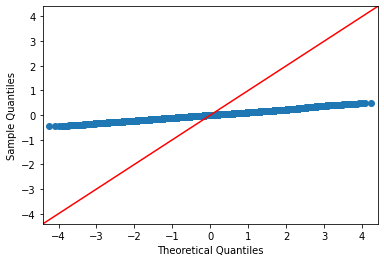


GF combined score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
architecture,13.752175,11.0,121.501863,7.629824e-278,0.75
landscape,536.928674,2.0,26091.006857,0.000000e+00,29.47
demography,124.605920,4.0,3027.491421,0.000000e+00,6.84
Garden ID,196.970828,99.0,193.361921,0.000000e+00,10.81
"$\^p_{clinal, temp}$",2.322514,1.0,225.716148,5.910190e-51,0.13
"$\^p_{clinal, Env2}$",3.031841,1.0,294.652846,6.139444e-66,0.17
Degree of\nlocal adaptation,19.328826,1.0,1878.493539,0.000000e+00,1.06
Residual,924.823436,89880.0,NaN,NaN,50.77


Model:              OLS              Adj. R-squared:     0.810       
Dependent Variable: score            AIC:                -156367.6539
Date:               2023-02-09 11:03 BIC:                -155238.7461
No. Observations:   90000            Log-Likelihood:     78304.      
Df Model:           119              F-statistic:        3218.       
Df Residuals:       89880            Prob (F-statistic): 0.00        
R-squared:          0.810            Scale:              0.010290    


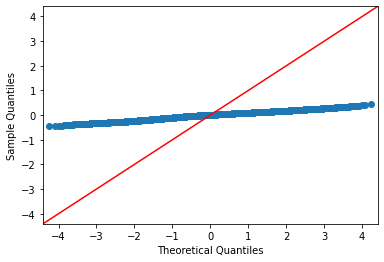


rda combined score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
architecture,16.841472,11.0,122.573675,2.381909e-280,0.82
landscape,568.897267,2.0,22772.656379,0.000000e+00,27.66
demography,131.135387,4.0,2624.640053,0.000000e+00,6.38
Garden ID,190.119174,99.0,153.744846,0.000000e+00,9.24
"$\^p_{clinal, temp}$",4.672724,1.0,374.093364,3.551734e-83,0.23
"$\^p_{clinal, Env2}$",3.567932,1.0,285.644836,5.553594e-64,0.17
Degree of\nlocal adaptation,18.747236,1.0,1500.883887,0.000000e+00,0.91
Residual,1122.672857,89880.0,NaN,NaN,54.59


Model:              OLS              Adj. R-squared:     0.787       
Dependent Variable: score            AIC:                -138919.8254
Date:               2023-02-09 11:03 BIC:                -137790.9176
No. Observations:   90000            Log-Likelihood:     69580.      
Df Model:           119              F-statistic:        2798.       
Df Residuals:       89880            Prob (F-statistic): 0.00        
R-squared:          0.787            Scale:              0.012491    


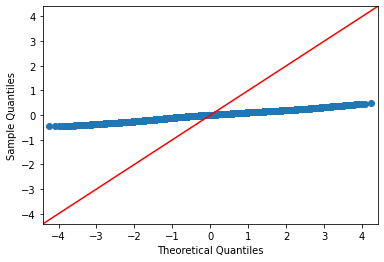

In [12]:
formula_key = 'combined'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)


RONA combined_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
architecture,4.115123,11.0,7.474420,5.527744e-13,0.04
landscape,220.518986,2.0,2202.943427,0.000000e+00,1.98
demography,213.774200,4.0,1067.782138,0.000000e+00,1.92
Garden ID,1251.323326,99.0,252.535071,0.000000e+00,11.22
"$\^p_{clinal, temp}$",0.660727,1.0,13.201071,2.798670e-04,0.01
"$\^p_{clinal, Env2}$",0.100173,1.0,2.001412,1.571545e-01,0.00
Degree of\nlocal adaptation,29.352883,1.0,586.459631,2.382174e-129,0.26
final_LA:architecture,8.593559,11.0,15.608735,5.478748e-31,0.08
final_LA:landscape,18.492727,2.0,184.738883,7.100016e-81,0.17
final_LA:C(garden),400.796558,99.0,80.886518,0.000000e+00,3.59


Model:              OLS              Adj. R-squared:     0.270      
Dependent Variable: score            AIC:                -27998.6269
Date:               2023-02-09 11:03 BIC:                -25655.2617
No. Observations:   180000           Log-Likelihood:     14231.     
Df Model:           231              F-statistic:        288.8      
Df Residuals:       179768           Prob (F-statistic): 0.00       
R-squared:          0.271            Scale:              0.050051   


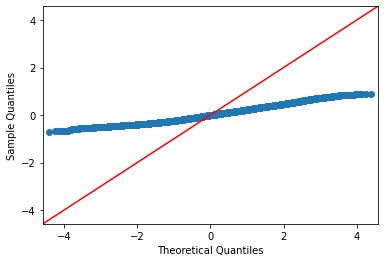


lfmm2 combined_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
architecture,20.619449,11.0,179.254823,0.000000e+00,1.38
landscape,68.338486,2.0,3267.546984,0.000000e+00,4.58
demography,146.172819,4.0,3494.564934,0.000000e+00,9.81
Garden ID,196.230674,99.0,189.547554,0.000000e+00,13.16
"$\^p_{clinal, temp}$",0.008882,1.0,0.849401,3.567243e-01,0.00
"$\^p_{clinal, Env2}$",0.002470,1.0,0.236183,6.269776e-01,0.00
Degree of\nlocal adaptation,13.682057,1.0,1308.392022,1.919894e-284,0.92
final_LA:architecture,2.071199,11.0,18.005932,2.070120e-36,0.14
final_LA:landscape,33.414403,2.0,1597.681465,0.000000e+00,2.24
final_LA:C(garden),71.346581,99.0,68.916697,0.000000e+00,4.79


Model:              OLS              Adj. R-squared:     0.720       
Dependent Variable: score            AIC:                -154801.5659
Date:               2023-02-09 11:03 BIC:                -152619.0109
No. Observations:   90000            Log-Likelihood:     77633.      
Df Model:           231              F-statistic:        1001.       
Df Residuals:       89768            Prob (F-statistic): 0.00        
R-squared:          0.720            Scale:              0.010457    


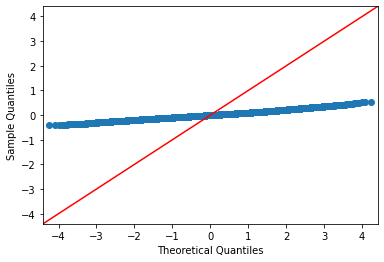


GF combined_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
architecture,22.912434,11.0,227.317619,0.000000e+00,1.32
landscape,495.557545,2.0,27040.745599,0.000000e+00,28.45
demography,120.514650,4.0,3288.019744,0.000000e+00,6.92
Garden ID,196.970828,99.0,217.130724,0.000000e+00,11.31
"$\^p_{clinal, temp}$",1.011582,1.0,110.396635,8.303918e-26,0.06
"$\^p_{clinal, Env2}$",0.450800,1.0,49.197038,2.331285e-12,0.03
Degree of\nlocal adaptation,19.328826,1.0,2109.405306,0.000000e+00,1.11
final_LA:architecture,1.840167,11.0,18.256564,5.563352e-37,0.11
final_LA:landscape,13.638891,2.0,744.223944,2.742064e-321,0.78
final_LA:C(garden),47.236557,99.0,52.071202,0.000000e+00,2.71


Model:              OLS              Adj. R-squared:     0.830       
Dependent Variable: score            AIC:                -166690.1058
Date:               2023-02-09 11:03 BIC:                -164507.5507
No. Observations:   90000            Log-Likelihood:     83577.      
Df Model:           231              F-statistic:        1910.       
Df Residuals:       89768            Prob (F-statistic): 0.00        
R-squared:          0.831            Scale:              0.0091632   


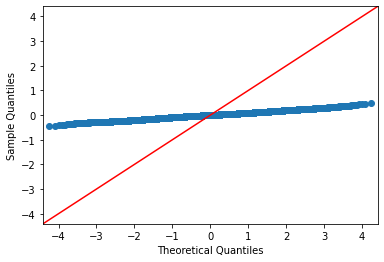


rda combined_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
architecture,24.171072,11.0,199.644451,0.000000e+00,1.23
landscape,530.041055,2.0,24078.727500,0.000000e+00,26.89
demography,132.709268,4.0,3014.361120,0.000000e+00,6.73
Garden ID,190.119174,99.0,174.479634,0.000000e+00,9.65
"$\^p_{clinal, temp}$",2.501460,1.0,227.272818,2.710360e-51,0.13
"$\^p_{clinal, Env2}$",0.371004,1.0,33.707983,6.425218e-09,0.02
Degree of\nlocal adaptation,18.747236,1.0,1703.300492,0.000000e+00,0.95
final_LA:architecture,3.840204,11.0,31.718714,5.694165e-68,0.19
final_LA:landscape,32.466270,2.0,1474.879069,0.000000e+00,1.65
final_LA:C(garden),47.982100,99.0,44.035007,0.000000e+00,2.43


Model:              OLS              Adj. R-squared:     0.812       
Dependent Variable: score            AIC:                -150194.2727
Date:               2023-02-09 11:03 BIC:                -148011.7176
No. Observations:   90000            Log-Likelihood:     75329.      
Df Model:           231              F-statistic:        1689.       
Df Residuals:       89768            Prob (F-statistic): 0.00        
R-squared:          0.813            Scale:              0.011006    


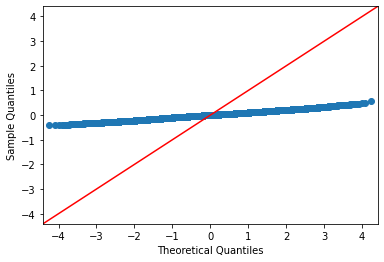

In [13]:
formula_key = 'combined_interactions'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)

<a id='sanity_anova'></a>
### sanity check
[top](#home)


RONA withLA_woArch score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
landscape,328.456199,2.0,3119.502546,0.000000e+00,2.73
demography,265.553618,4.0,1261.043619,0.000000e+00,2.21
Garden ID,1251.323326,99.0,240.088978,0.000000e+00,10.40
"$\^p_{clinal, temp}$",4.117009,1.0,78.202335,9.382242e-19,0.03
"$\^p_{clinal, Env2}$",0.952877,1.0,18.099839,2.097250e-05,0.01
Degree of\nlocal adaptation,714.767662,1.0,13576.967335,0.000000e+00,5.94
Residual,9470.470557,179891.0,NaN,NaN,78.69


Model:              OLS              Adj. R-squared:     0.232      
Dependent Variable: score            AIC:                -19024.2141
Date:               2023-02-09 11:03 BIC:                -17923.2365
No. Observations:   180000           Log-Likelihood:     9621.1     
Df Model:           108              F-statistic:        504.1      
Df Residuals:       179891           Prob (F-statistic): 0.00       
R-squared:          0.232            Scale:              0.052646   


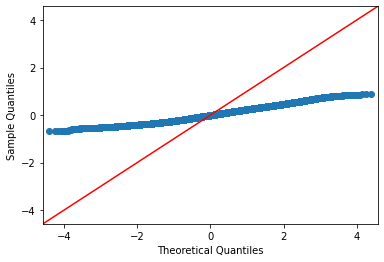


lfmm2 withLA_woArch score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
landscape,85.406017,2.0,3377.158005,0.000000e+00,3.08
demography,133.841420,4.0,2646.204791,0.000000e+00,4.83
Garden ID,196.230674,99.0,156.756156,0.000000e+00,7.09
"$\^p_{clinal, temp}$",1.146776,1.0,90.692527,1.717927e-21,0.04
"$\^p_{clinal, Env2}$",0.580835,1.0,45.935218,1.229790e-11,0.02
Degree of\nlocal adaptation,1215.626665,1.0,96137.566176,0.000000e+00,43.89
Residual,1136.640970,89891.0,NaN,NaN,41.04


Model:              OLS              Adj. R-squared:     0.661       
Dependent Variable: score            AIC:                -137828.9687
Date:               2023-02-09 11:03 BIC:                -136803.5442
No. Observations:   90000            Log-Likelihood:     69023.      
Df Model:           108              F-statistic:        1626.       
Df Residuals:       89891            Prob (F-statistic): 0.00        
R-squared:          0.661            Scale:              0.012645    


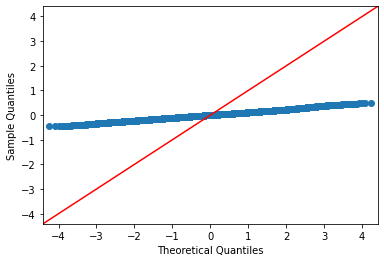


GF withLA_woArch score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
landscape,770.255345,2.0,36885.160025,0.000000e+00,19.12
demography,148.520135,4.0,3556.086294,0.000000e+00,3.69
Garden ID,196.970828,99.0,190.552066,0.000000e+00,4.89
"$\^p_{clinal, temp}$",3.762020,1.0,360.303118,3.474002e-80,0.09
"$\^p_{clinal, Env2}$",3.325577,1.0,318.503337,4.073011e-71,0.08
Degree of\nlocal adaptation,1967.886312,1.0,188472.048868,0.000000e+00,48.84
Residual,938.575611,89891.0,NaN,NaN,23.29


Model:              OLS              Adj. R-squared:     0.807       
Dependent Variable: score            AIC:                -155061.2018
Date:               2023-02-09 11:03 BIC:                -154035.7772
No. Observations:   90000            Log-Likelihood:     77640.      
Df Model:           108              F-statistic:        3482.       
Df Residuals:       89891            Prob (F-statistic): 0.00        
R-squared:          0.807            Scale:              0.010441    


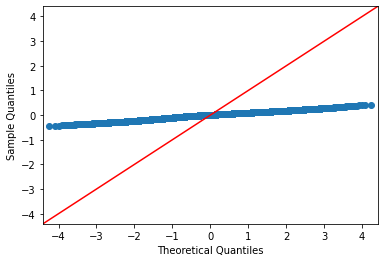


rda withLA_woArch score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
landscape,752.896129,2.0,29696.241741,0.000000e+00,18.25
demography,144.694661,4.0,2853.572673,0.000000e+00,3.51
Garden ID,190.119174,99.0,151.491109,0.000000e+00,4.61
"$\^p_{clinal, temp}$",4.907851,1.0,387.157598,5.225587e-86,0.12
"$\^p_{clinal, Env2}$",5.016691,1.0,395.743511,7.196032e-88,0.12
Degree of\nlocal adaptation,1887.518934,1.0,148897.613853,0.000000e+00,45.76
Residual,1139.514329,89891.0,NaN,NaN,27.63


Model:              OLS              Adj. R-squared:     0.784       
Dependent Variable: score            AIC:                -137601.7414
Date:               2023-02-09 11:03 BIC:                -136576.3168
No. Observations:   90000            Log-Likelihood:     68910.      
Df Model:           108              F-statistic:        3026.       
Df Residuals:       89891            Prob (F-statistic): 0.00        
R-squared:          0.784            Scale:              0.012677    


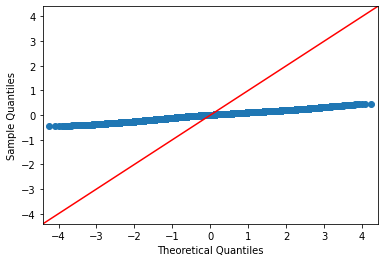

In [14]:
formula_key = 'withLA_woArch'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)


RONA withLA_woArch_interactions score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
landscape,261.361902,2.0,2608.413624,0.000000e+00,2.20
demography,212.547944,4.0,1060.623123,0.000000e+00,1.79
Garden ID,1251.323326,99.0,252.289118,0.000000e+00,10.52
"$\^p_{clinal, temp}$",0.459156,1.0,9.164831,2.467453e-03,0.00
"$\^p_{clinal, Env2}$",1.077733,1.0,21.511737,3.519167e-06,0.01
Degree of\nlocal adaptation,714.767662,1.0,14266.881984,0.000000e+00,6.01
final_LA:architecture,3.386021,11.0,6.144140,3.522647e-10,0.03
final_LA:landscape,45.099091,2.0,450.092693,1.035102e-195,0.38
final_LA:C(garden),400.796558,99.0,80.807740,0.000000e+00,3.37
final_LA:slevel,0.238153,1.0,4.753574,2.923881e-02,0.00


Model:              OLS              Adj. R-squared:     0.269      
Dependent Variable: score            AIC:                -27834.2198
Date:               2023-02-09 11:03 BIC:                -25601.9624
No. Observations:   180000           Log-Likelihood:     14138.     
Df Model:           220              F-statistic:        302.1      
Df Residuals:       179779           Prob (F-statistic): 0.00       
R-squared:          0.270            Scale:              0.050100   


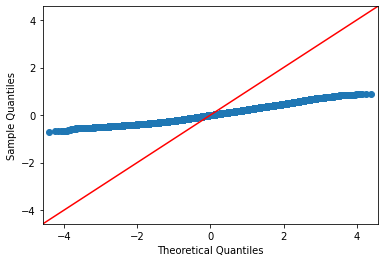


lfmm2 withLA_woArch_interactions score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
landscape,69.719455,2.0,3321.976649,0.000000e+00,2.50
demography,146.238166,4.0,3483.961356,0.000000e+00,5.24
Garden ID,196.230674,99.0,188.887966,0.000000e+00,7.03
"$\^p_{clinal, temp}$",0.120670,1.0,11.499276,6.965331e-04,0.00
"$\^p_{clinal, Env2}$",0.014594,1.0,1.390701,2.382898e-01,0.00
Degree of\nlocal adaptation,1215.626665,1.0,115843.803135,0.000000e+00,43.57
final_LA:architecture,19.297256,11.0,167.176587,0.000000e+00,0.69
final_LA:landscape,115.120058,2.0,5485.214207,0.000000e+00,4.13
final_LA:C(garden),71.346581,99.0,68.676880,0.000000e+00,2.56
final_LA:slevel,14.388311,1.0,1371.141911,7.037274e-298,0.52


Model:              OLS              Adj. R-squared:     0.719       
Dependent Variable: score            AIC:                -154498.8096
Date:               2023-02-09 11:03 BIC:                -152419.7377
No. Observations:   90000            Log-Likelihood:     77470.      
Df Model:           220              F-statistic:        1046.       
Df Residuals:       89779            Prob (F-statistic): 0.00        
R-squared:          0.719            Scale:              0.010494    


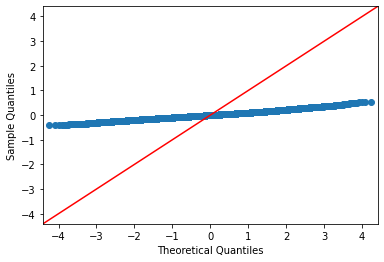


GF withLA_woArch_interactions score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
landscape,546.407473,2.0,29690.875456,0.000000e+00,14.37
demography,120.679843,4.0,3278.771217,0.000000e+00,3.17
Garden ID,196.970828,99.0,216.223595,0.000000e+00,5.18
"$\^p_{clinal, temp}$",1.222685,1.0,132.877308,1.010919e-30,0.03
"$\^p_{clinal, Env2}$",1.201448,1.0,130.569337,3.227715e-30,0.03
Degree of\nlocal adaptation,1967.886312,1.0,213863.353744,0.000000e+00,51.76
final_LA:architecture,21.200477,11.0,209.454316,0.000000e+00,0.56
final_LA:landscape,58.882379,2.0,3199.570752,0.000000e+00,1.55
final_LA:C(garden),47.236557,99.0,51.853659,0.000000e+00,1.24
final_LA:slevel,13.935622,1.0,1514.477115,0.000000e+00,0.37


Model:              OLS              Adj. R-squared:     0.830       
Dependent Variable: score            AIC:                -166324.2882
Date:               2023-02-09 11:03 BIC:                -164245.2163
No. Observations:   90000            Log-Likelihood:     83383.      
Df Model:           220              F-statistic:        1995.       
Df Residuals:       89779            Prob (F-statistic): 0.00        
R-squared:          0.830            Scale:              0.0092016   


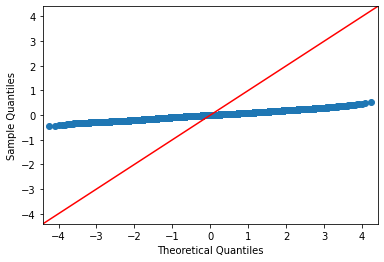


rda withLA_woArch_interactions score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
landscape,570.092837,2.0,25766.432585,0.000000e+00,14.44
demography,132.095538,4.0,2985.154819,0.000000e+00,3.35
Garden ID,190.119174,99.0,173.591889,0.000000e+00,4.81
"$\^p_{clinal, temp}$",2.988534,1.0,270.144991,1.294314e-60,0.08
"$\^p_{clinal, Env2}$",1.262207,1.0,114.095737,1.288276e-26,0.03
Degree of\nlocal adaptation,1887.518934,1.0,170620.033027,0.000000e+00,47.80
final_LA:architecture,22.836852,11.0,187.664559,0.000000e+00,0.58
final_LA:landscape,88.385213,2.0,3994.738206,0.000000e+00,2.24
final_LA:C(garden),47.982100,99.0,43.810959,0.000000e+00,1.22
final_LA:slevel,12.500803,1.0,1129.995256,3.417764e-246,0.32


Model:              OLS              Adj. R-squared:     0.811       
Dependent Variable: score            AIC:                -149746.1597
Date:               2023-02-09 11:03 BIC:                -147667.0879
No. Observations:   90000            Log-Likelihood:     75094.      
Df Model:           220              F-statistic:        1762.       
Df Residuals:       89779            Prob (F-statistic): 0.00        
R-squared:          0.812            Scale:              0.011063    


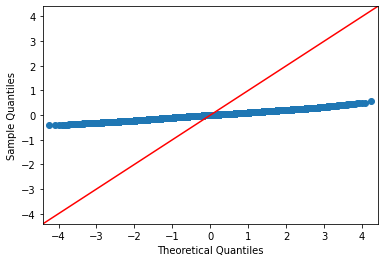

In [15]:
formula_key = 'withLA_woArch_interactions'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)


RONA woLA_withArch score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
architecture,690.751468,11.0,1189.714985,0.000000e+00,5.77
landscape,202.070113,2.0,1914.193726,0.000000e+00,1.69
demography,330.017818,4.0,1563.115959,0.000000e+00,2.76
Garden ID,1251.323326,99.0,239.468364,0.000000e+00,10.45
"$\^p_{clinal, temp}$",1.999370,1.0,37.879733,7.540087e-10,0.02
"$\^p_{clinal, Env2}$",2.110623,1.0,39.987523,2.561869e-10,0.02
Residual,9494.486750,179881.0,NaN,NaN,79.30


Model:              OLS              Adj. R-squared:     0.230      
Dependent Variable: score            AIC:                -18548.3294
Date:               2023-02-09 11:03 BIC:                -17346.3446
No. Observations:   180000           Log-Likelihood:     9393.2     
Df Model:           118              F-statistic:        456.3      
Df Residuals:       179881           Prob (F-statistic): 0.00       
R-squared:          0.230            Scale:              0.052782   


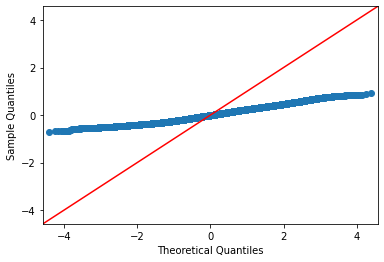


lfmm2 woLA_withArch score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
architecture,1209.906883,11.0,8654.139351,0.000000e+00,42.80
landscape,111.379973,2.0,4381.690854,0.000000e+00,3.94
demography,164.812147,4.0,3241.856956,0.000000e+00,5.83
Garden ID,196.230674,99.0,155.953930,0.000000e+00,6.94
"$\^p_{clinal, temp}$",1.836058,1.0,144.461126,2.987469e-33,0.06
"$\^p_{clinal, Env2}$",0.654169,1.0,51.470039,7.325639e-13,0.02
Residual,1142.360752,89881.0,NaN,NaN,40.41


Model:              OLS              Adj. R-squared:     0.659       
Dependent Variable: score            AIC:                -137357.2083
Date:               2023-02-09 11:03 BIC:                -136237.7080
No. Observations:   90000            Log-Likelihood:     68798.      
Df Model:           118              F-statistic:        1477.       
Df Residuals:       89881            Prob (F-statistic): 0.00        
R-squared:          0.660            Scale:              0.012710    


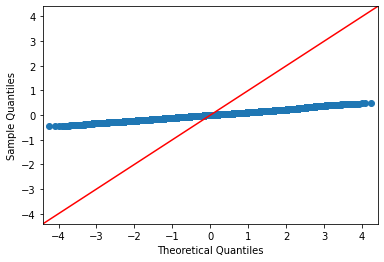


GF woLA_withArch score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
architecture,1962.309661,11.0,16982.464467,0.000000e+00,52.37
landscape,526.046772,2.0,25039.186921,0.000000e+00,14.04
demography,111.653362,4.0,2657.282161,0.000000e+00,2.98
Garden ID,196.970828,99.0,189.405494,0.000000e+00,5.26
"$\^p_{clinal, temp}$",3.443984,1.0,327.858914,3.797033e-73,0.09
"$\^p_{clinal, Env2}$",2.693826,1.0,256.445681,1.228008e-57,0.07
Residual,944.152262,89881.0,NaN,NaN,25.20


Model:              OLS              Adj. R-squared:     0.806       
Dependent Variable: score            AIC:                -154508.0392
Date:               2023-02-09 11:03 BIC:                -153388.5390
No. Observations:   90000            Log-Likelihood:     77373.      
Df Model:           118              F-statistic:        3163.       
Df Residuals:       89881            Prob (F-statistic): 0.00        
R-squared:          0.806            Scale:              0.010504    


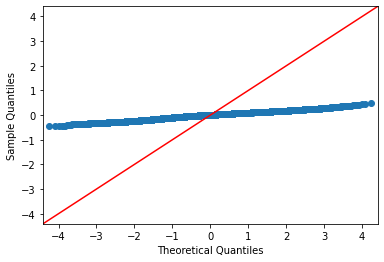


rda woLA_withArch score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + C(garden)


,sum_sq,df,F,PR(>F),perc_sum_sq
architecture,1885.613170,11.0,13498.400199,0.000000e+00,48.01
landscape,575.669559,2.0,22665.518119,0.000000e+00,14.66
demography,125.154254,4.0,2463.814503,0.000000e+00,3.19
Garden ID,190.119174,99.0,151.221349,0.000000e+00,4.84
"$\^p_{clinal, temp}$",6.201434,1.0,488.331231,6.384346e-108,0.16
"$\^p_{clinal, Env2}$",3.205987,1.0,252.455063,9.050581e-57,0.08
Residual,1141.420093,89881.0,NaN,NaN,29.06


Model:              OLS              Adj. R-squared:     0.784       
Dependent Variable: score            AIC:                -137431.3479
Date:               2023-02-09 11:03 BIC:                -136311.8477
No. Observations:   90000            Log-Likelihood:     68835.      
Df Model:           118              F-statistic:        2763.       
Df Residuals:       89881            Prob (F-statistic): 0.00        
R-squared:          0.784            Scale:              0.012699    


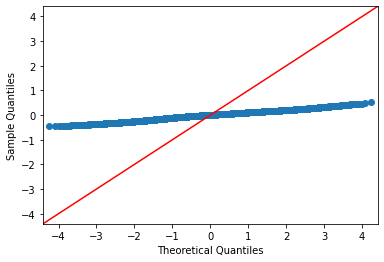

In [16]:
formula_key = 'woLA_withArch'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)


RONA woLA_withArch_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
architecture,9.725701,11.0,17.665078,1.176935e-35,0.09
landscape,220.518986,2.0,2202.943427,0.000000e+00,1.98
demography,213.774200,4.0,1067.782138,0.000000e+00,1.92
Garden ID,1251.323326,99.0,252.535071,0.000000e+00,11.23
"$\^p_{clinal, temp}$",0.660727,1.0,13.201071,2.798670e-04,0.01
"$\^p_{clinal, Env2}$",0.100173,1.0,2.001412,1.571545e-01,0.00
final_LA:architecture,18.109563,12.0,30.151858,5.323589e-70,0.16
final_LA:landscape,18.492727,2.0,184.738883,7.100016e-81,0.17
final_LA:C(garden),400.796558,99.0,80.886518,0.000000e+00,3.60
final_LA:slevel,10.056490,1.0,200.924900,1.388694e-45,0.09


Model:              OLS              Adj. R-squared:     0.270      
Dependent Variable: score            AIC:                -27998.6269
Date:               2023-02-09 11:03 BIC:                -25655.2617
No. Observations:   180000           Log-Likelihood:     14231.     
Df Model:           231              F-statistic:        288.8      
Df Residuals:       179768           Prob (F-statistic): 0.00       
R-squared:          0.271            Scale:              0.050051   


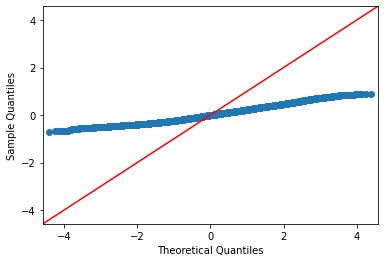


lfmm2 woLA_withArch_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
architecture,54.871514,11.0,477.024562,0.000000e+00,3.60
landscape,68.338486,2.0,3267.546984,0.000000e+00,4.48
demography,146.172819,4.0,3494.564934,0.000000e+00,9.58
Garden ID,196.230674,99.0,189.547554,0.000000e+00,12.86
"$\^p_{clinal, temp}$",0.008882,1.0,0.849401,3.567243e-01,0.00
"$\^p_{clinal, Env2}$",0.002470,1.0,0.236183,6.269776e-01,0.00
final_LA:architecture,9.734112,12.0,77.571389,1.413767e-190,0.64
final_LA:landscape,33.414403,2.0,1597.681465,0.000000e+00,2.19
final_LA:C(garden),71.346581,99.0,68.916697,0.000000e+00,4.68
final_LA:slevel,7.187675,1.0,687.345173,6.277495e-151,0.47


Model:              OLS              Adj. R-squared:     0.720       
Dependent Variable: score            AIC:                -154801.5659
Date:               2023-02-09 11:04 BIC:                -152619.0109
No. Observations:   90000            Log-Likelihood:     77633.      
Df Model:           231              F-statistic:        1001.       
Df Residuals:       89768            Prob (F-statistic): 0.00        
R-squared:          0.720            Scale:              0.010457    


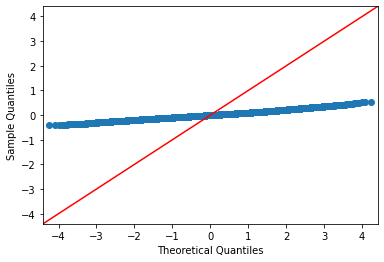


GF woLA_withArch_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
architecture,56.768789,11.0,563.211499,0.000000e+00,3.21
landscape,495.557545,2.0,27040.745599,0.000000e+00,27.99
demography,120.514650,4.0,3288.019744,0.000000e+00,6.81
Garden ID,196.970828,99.0,217.130724,0.000000e+00,11.12
"$\^p_{clinal, temp}$",1.011582,1.0,110.396635,8.303918e-26,0.06
"$\^p_{clinal, Env2}$",0.450800,1.0,49.197038,2.331285e-12,0.03
final_LA:architecture,9.272036,12.0,84.323464,8.381299e-208,0.52
final_LA:landscape,13.638891,2.0,744.223944,2.742064e-321,0.77
final_LA:C(garden),47.236557,99.0,52.071202,0.000000e+00,2.67
final_LA:slevel,6.575826,1.0,717.637050,1.827253e-157,0.37


Model:              OLS              Adj. R-squared:     0.830       
Dependent Variable: score            AIC:                -166690.1058
Date:               2023-02-09 11:04 BIC:                -164507.5507
No. Observations:   90000            Log-Likelihood:     83577.      
Df Model:           231              F-statistic:        1910.       
Df Residuals:       89768            Prob (F-statistic): 0.00        
R-squared:          0.831            Scale:              0.0091632   


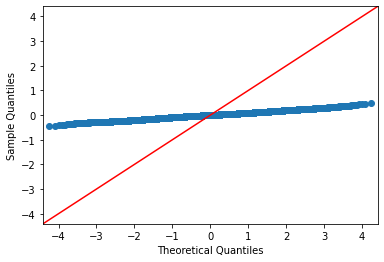


rda woLA_withArch_interactions score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel


,sum_sq,df,F,PR(>F),perc_sum_sq
architecture,57.829586,11.0,477.651798,0.000000e+00,2.89
landscape,530.041055,2.0,24078.727500,0.000000e+00,26.47
demography,132.709268,4.0,3014.361120,0.000000e+00,6.63
Garden ID,190.119174,99.0,174.479634,0.000000e+00,9.49
"$\^p_{clinal, temp}$",2.501460,1.0,227.272818,2.710360e-51,0.12
"$\^p_{clinal, Env2}$",0.371004,1.0,33.707983,6.425218e-09,0.02
final_LA:architecture,12.602505,12.0,95.417857,4.186119e-236,0.63
final_LA:landscape,32.466270,2.0,1474.879069,0.000000e+00,1.62
final_LA:C(garden),47.982100,99.0,44.035007,0.000000e+00,2.40
final_LA:slevel,7.884307,1.0,716.337251,3.484972e-157,0.39


Model:              OLS              Adj. R-squared:     0.812       
Dependent Variable: score            AIC:                -150194.2727
Date:               2023-02-09 11:04 BIC:                -148011.7176
No. Observations:   90000            Log-Likelihood:     75329.      
Df Model:           231              F-statistic:        1689.       
Df Residuals:       89768            Prob (F-statistic): 0.00        
R-squared:          0.813            Scale:              0.011006    


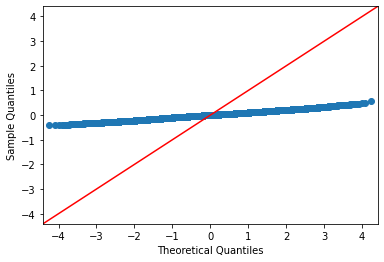

In [17]:
formula_key = 'woLA_withArch_interactions'
lms[formula_key], res[formula_key], sos[formula_key] = get_anova(formula_key)

<a id='sos'></a>
# 3. look at percent sum of squares of factors across methods

[top](#home)

In [18]:
def create_perc_boxplot(formula_key):
    """Calculate and visualize percent sum of squares from factors."""
    percdf = pd.DataFrame(
        [pd.Series(method_df['perc_sum_sq'], name=method)
         for method, method_df in res[formula_key].items()]
    )

    df = pd.DataFrame(columns=['factor', 'program', 'perc'])
    for factor in percdf.columns:
        for program in percdf.index:
            df.loc[nrow(df)] = [factor, program, percdf.loc[program, factor]]
#     print('set(df.factor) - set(mvp.factor_names) = ', set(df.factor) - set(mvp.factor_names))
#     print('set(mvp.factor_names) - set(df.factor) = ', set(mvp.factor_names) - set(df.factor))

    assert df.factor.notnull().all()

    ax = sns.boxplot(data=df, x='factor', y='perc')
    ax.set_ylabel('percentage sum of squares')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_ylim((0, 100))
    plt.draw()  # so ticklabels populate after changing ylim
    ax.set_yticks(ax.get_yticks())  # supresses FixedLocator warning
    ax.set_title(f'{formula_key = }')
    
    # reset ylabels to percentages
    nums = [tick.get_text() for tick in ax.get_yticklabels()]
    ax.set_yticklabels([f'{num}%' for num in nums])
    
    # add horizontal lines
    for y in range(0, 100, 10):
        ax.axhline(y=y, color='gainsboro', zorder=0, alpha=0.3)
    
    save_pdf(op.join(figdir, f'anova_sos_{formula_key}.pdf'))

    plt.show()       
    
    display(percdf)
    
    return df

<a id='ss_anova_sos'></a>
### super simple (excludes slevel)

[top](#home)

percentage sum of squares (super_simple factors)
score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)
architecture = glevel
pleiotropy = plevel_pleio
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/figs/anova_sos_super_simple.pdf


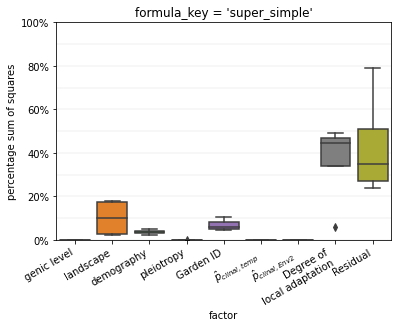

,genic level,landscape,demography,pleiotropy,Garden ID,"$\^p_{clinal, temp}$","$\^p_{clinal, Env2}$",Degree of\nlocal adaptation,Residual
RONA,0.01,2.43,2.23,0.00,10.45,0.02,0.02,5.76,79.09
lfmm2,0.01,2.82,4.90,0.00,7.19,0.02,0.01,43.42,41.62
GF,0.01,17.95,3.81,0.01,5.04,0.06,0.05,49.08,23.99
rda,0.01,17.09,3.62,0.00,4.74,0.10,0.07,46.00,28.38


,factor,program,perc
0,genic level,RONA,0.01
1,genic level,lfmm2,0.01
2,genic level,GF,0.01
3,genic level,rda,0.01
4,landscape,RONA,2.43
5,landscape,lfmm2,2.82
6,landscape,GF,17.95
7,landscape,rda,17.09
8,demography,RONA,2.23
9,demography,lfmm2,4.90


In [19]:
formula_key = 'super_simple'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel')
print('pleiotropy = plevel_pleio')

df = create_perc_boxplot(formula_key)

df

percentage sum of squares (super_simple factors)
score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)
architecture = glevel
pleiotropy = plevel_pleio
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/figs/anova_sos_super_simple.pdf


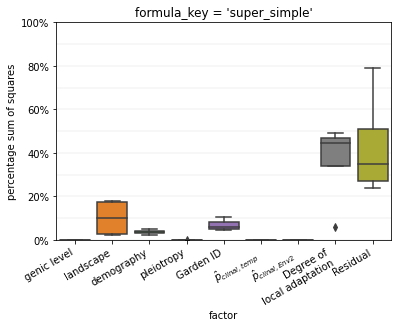

,genic level,landscape,demography,pleiotropy,Garden ID,"$\^p_{clinal, temp}$","$\^p_{clinal, Env2}$",Degree of\nlocal adaptation,Residual
RONA,0.01,2.43,2.23,0.00,10.45,0.02,0.02,5.76,79.09
lfmm2,0.01,2.82,4.90,0.00,7.19,0.02,0.01,43.42,41.62
GF,0.01,17.95,3.81,0.01,5.04,0.06,0.05,49.08,23.99
rda,0.01,17.09,3.62,0.00,4.74,0.10,0.07,46.00,28.38


,factor,program,perc
0,genic level,RONA,0.01
1,genic level,lfmm2,0.01
2,genic level,GF,0.01
3,genic level,rda,0.01
4,landscape,RONA,2.43
5,landscape,lfmm2,2.82
6,landscape,GF,17.95
7,landscape,rda,17.09
8,demography,RONA,2.23
9,demography,lfmm2,4.90


In [20]:
formula_key = 'super_simple'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel')
print('pleiotropy = plevel_pleio')

df = create_perc_boxplot(formula_key)

df

percentage sum of squares (super_simple_interactions factors)
score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
architecture = glevel
pleiotropy = plevel_pleio
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/figs/anova_sos_super_simple_interactions.pdf


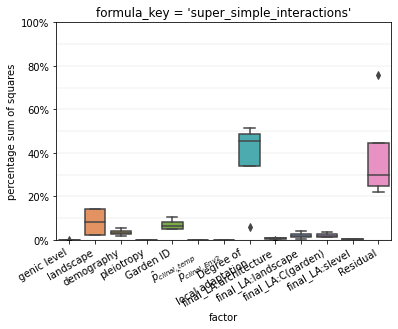

,genic level,landscape,demography,pleiotropy,Garden ID,"$\^p_{clinal, temp}$","$\^p_{clinal, Env2}$",Degree of\nlocal adaptation,final_LA:architecture,final_LA:landscape,final_LA:C(garden),final_LA:slevel,Residual
RONA,0.02,2.20,1.78,0.00,10.54,0.01,0.00,5.81,0.04,0.39,3.38,0.00,75.84
lfmm2,0.00,2.44,5.32,0.02,7.14,0.00,0.00,43.13,0.70,4.11,2.60,0.27,34.27
GF,0.02,14.23,3.25,0.01,5.28,0.03,0.01,51.45,0.57,1.58,1.27,0.16,22.13
rda,0.03,14.20,3.42,0.01,4.90,0.07,0.01,47.56,0.62,2.27,1.24,0.12,25.55


,factor,program,perc
0,genic level,RONA,0.02
1,genic level,lfmm2,0.00
2,genic level,GF,0.02
3,genic level,rda,0.03
4,landscape,RONA,2.20
5,landscape,lfmm2,2.44
6,landscape,GF,14.23
7,landscape,rda,14.20
8,demography,RONA,1.78
9,demography,lfmm2,5.32


In [21]:
formula_key = 'super_simple_interactions'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel')
print('pleiotropy = plevel_pleio')

df = create_perc_boxplot(formula_key)

df

<a id='simp_anova_sos'></a>
### simple factors
    
[top](#home)

percentage sum of squares (simple factors)
score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + final_LA  + C(garden)
architecture = glevel
pleiotropy = plevel_pleio
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/figs/anova_sos_simple.pdf


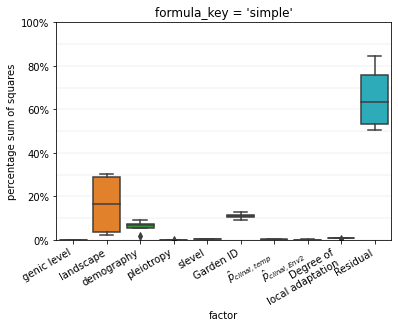

,genic level,landscape,demography,pleiotropy,slevel,Garden ID,"$\^p_{clinal, temp}$","$\^p_{clinal, Env2}$",Degree of\nlocal adaptation,Residual
RONA,0.01,2.11,1.94,0.00,0.01,11.17,0.02,0.02,0.24,84.49
lfmm2,0.03,4.30,8.91,0.00,0.30,12.64,0.05,0.03,0.84,72.90
GF,0.04,30.32,6.83,0.00,0.52,10.68,0.15,0.14,0.98,50.34
rda,0.02,28.42,6.43,0.01,0.44,9.14,0.22,0.17,0.84,54.32


,factor,program,perc
0,genic level,RONA,0.01
1,genic level,lfmm2,0.03
2,genic level,GF,0.04
3,genic level,rda,0.02
4,landscape,RONA,2.11
5,landscape,lfmm2,4.30
6,landscape,GF,30.32
7,landscape,rda,28.42
8,demography,RONA,1.94
9,demography,lfmm2,8.91


In [22]:
formula_key = 'simple'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel')
print('pleiotropy = plevel_pleio')

df = create_perc_boxplot(formula_key)

df

percentage sum of squares (simple_interactions factors)
score ~ glevel + landscape + demography + plevel_pleio + cor_TPR_temp + slevel + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
architecture = glevel
pleiotropy = plevel_pleio
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/figs/anova_sos_simple_interactions.pdf


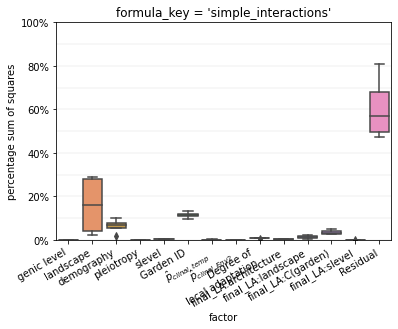

,genic level,landscape,demography,pleiotropy,slevel,Garden ID,"$\^p_{clinal, temp}$","$\^p_{clinal, Env2}$",Degree of\nlocal adaptation,final_LA:architecture,final_LA:landscape,final_LA:C(garden),final_LA:slevel,Residual
RONA,0.03,1.99,1.94,0.00,0.00,11.22,0.01,0.00,0.24,0.09,0.16,3.59,0.06,80.65
lfmm2,0.00,4.62,9.94,0.02,0.59,13.25,0.00,0.00,0.88,0.14,2.24,4.82,0.00,63.50
GF,0.05,29.10,6.91,0.01,0.43,11.32,0.07,0.03,1.04,0.20,0.77,2.72,0.02,47.33
rda,0.07,27.44,6.71,0.02,0.30,9.65,0.14,0.02,0.89,0.43,1.62,2.44,0.02,50.25


,factor,program,perc
0,genic level,RONA,0.03
1,genic level,lfmm2,0.00
2,genic level,GF,0.05
3,genic level,rda,0.07
4,landscape,RONA,1.99
5,landscape,lfmm2,4.62
6,landscape,GF,29.10
7,landscape,rda,27.44
8,demography,RONA,1.94
9,demography,lfmm2,9.94


In [23]:
formula_key = 'simple_interactions'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel')
print('pleiotropy = plevel_pleio')

df = create_perc_boxplot(formula_key)

df

<a id='comb_anova_sos'></a>
### combined factors

[top](#home)

percentage sum of squares (combined factors)
score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)
architecture = glevel + plevel + pleio + slevel
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/figs/anova_sos_combined.pdf


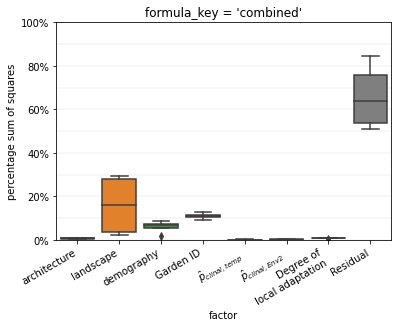

,architecture,landscape,demography,Garden ID,"$\^p_{clinal, temp}$","$\^p_{clinal, Env2}$",Degree of\nlocal adaptation,Residual
RONA,0.05,2.04,1.90,11.18,0.01,0.02,0.26,84.54
lfmm2,0.51,4.01,8.83,12.68,0.07,0.05,0.88,72.95
GF,0.75,29.47,6.84,10.81,0.13,0.17,1.06,50.77
rda,0.82,27.66,6.38,9.24,0.23,0.17,0.91,54.59


,factor,program,perc
0,architecture,RONA,0.05
1,architecture,lfmm2,0.51
2,architecture,GF,0.75
3,architecture,rda,0.82
4,landscape,RONA,2.04
5,landscape,lfmm2,4.01
6,landscape,GF,29.47
7,landscape,rda,27.66
8,demography,RONA,1.90
9,demography,lfmm2,8.83


In [24]:
formula_key = 'combined'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel + plevel + pleio + slevel')

df = create_perc_boxplot(formula_key)

df

percentage sum of squares (combined_interactions factors)
score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
architecture = glevel + plevel + pleio + slevel
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/figs/anova_sos_combined_interactions.pdf


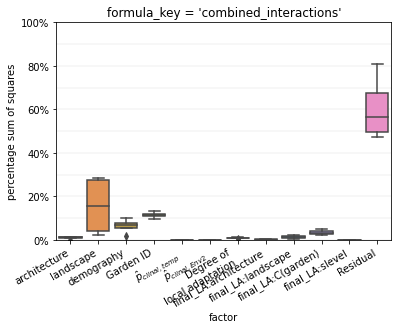

,architecture,landscape,demography,Garden ID,"$\^p_{clinal, temp}$","$\^p_{clinal, Env2}$",Degree of\nlocal adaptation,final_LA:architecture,final_LA:landscape,final_LA:C(garden),final_LA:slevel,Residual
RONA,0.04,1.98,1.92,11.22,0.01,0.00,0.26,0.08,0.17,3.59,0.03,80.70
lfmm2,1.38,4.58,9.81,13.16,0.00,0.00,0.92,0.14,2.24,4.79,0.01,62.97
GF,1.32,28.45,6.92,11.31,0.06,0.03,1.11,0.11,0.78,2.71,0.00,47.22
rda,1.23,26.89,6.73,9.65,0.13,0.02,0.95,0.19,1.65,2.43,0.00,50.13


,factor,program,perc
0,architecture,RONA,0.04
1,architecture,lfmm2,1.38
2,architecture,GF,1.32
3,architecture,rda,1.23
4,landscape,RONA,1.98
5,landscape,lfmm2,4.58
6,landscape,GF,28.45
7,landscape,rda,26.89
8,demography,RONA,1.92
9,demography,lfmm2,9.81


In [25]:
formula_key = 'combined_interactions'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel + plevel + pleio + slevel')

df = create_perc_boxplot(formula_key)

df

<a id='sanity_anova_sos'></a>
### sanity check

look for confounding between local adaptation and 'combined' architecture

[top](#home)

percentage sum of squares (withLA_woArch factors)
score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden)
architecture = glevel + plevel + pleio + slevel
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/figs/anova_sos_withLA_woArch.pdf


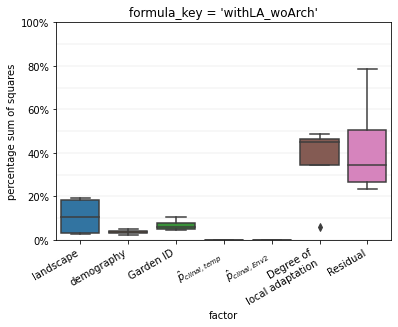

,landscape,demography,Garden ID,"$\^p_{clinal, temp}$","$\^p_{clinal, Env2}$",Degree of\nlocal adaptation,Residual
RONA,2.73,2.21,10.40,0.03,0.01,5.94,78.69
lfmm2,3.08,4.83,7.09,0.04,0.02,43.89,41.04
GF,19.12,3.69,4.89,0.09,0.08,48.84,23.29
rda,18.25,3.51,4.61,0.12,0.12,45.76,27.63


,factor,program,perc
0,landscape,RONA,2.73
1,landscape,lfmm2,3.08
2,landscape,GF,19.12
3,landscape,rda,18.25
4,demography,RONA,2.21
5,demography,lfmm2,4.83
6,demography,GF,3.69
7,demography,rda,3.51
8,Garden ID,RONA,10.40
9,Garden ID,lfmm2,7.09


In [26]:
formula_key = 'withLA_woArch'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel + plevel + pleio + slevel')

df = create_perc_boxplot(formula_key)

df

percentage sum of squares (withLA_woArch_interactions factors)
score ~ landscape + demography + cor_TPR_temp + cor_TPR_sal + final_LA  + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
architecture = glevel + plevel + pleio + slevel
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/figs/anova_sos_withLA_woArch_interactions.pdf


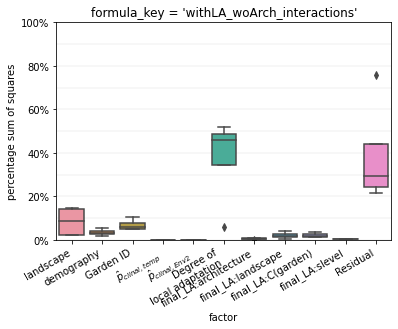

,landscape,demography,Garden ID,"$\^p_{clinal, temp}$","$\^p_{clinal, Env2}$",Degree of\nlocal adaptation,final_LA:architecture,final_LA:landscape,final_LA:C(garden),final_LA:slevel,Residual
RONA,2.20,1.79,10.52,0.00,0.01,6.01,0.03,0.38,3.37,0.00,75.70
lfmm2,2.50,5.24,7.03,0.00,0.00,43.57,0.69,4.13,2.56,0.52,33.76
GF,14.37,3.17,5.18,0.03,0.03,51.76,0.56,1.55,1.24,0.37,21.73
rda,14.44,3.35,4.81,0.08,0.03,47.80,0.58,2.24,1.22,0.32,25.15


,factor,program,perc
0,landscape,RONA,2.20
1,landscape,lfmm2,2.50
2,landscape,GF,14.37
3,landscape,rda,14.44
4,demography,RONA,1.79
5,demography,lfmm2,5.24
6,demography,GF,3.17
7,demography,rda,3.35
8,Garden ID,RONA,10.52
9,Garden ID,lfmm2,7.03


In [27]:
formula_key = 'withLA_woArch_interactions'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel + plevel + pleio + slevel')

df = create_perc_boxplot(formula_key)

df

percentage sum of squares (woLA_withArch factors)
score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + C(garden)
architecture = glevel + plevel + pleio + slevel
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/figs/anova_sos_woLA_withArch.pdf


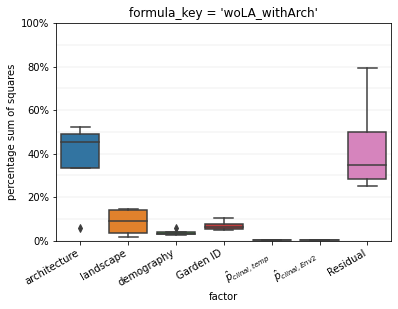

,architecture,landscape,demography,Garden ID,"$\^p_{clinal, temp}$","$\^p_{clinal, Env2}$",Residual
RONA,5.77,1.69,2.76,10.45,0.02,0.02,79.30
lfmm2,42.80,3.94,5.83,6.94,0.06,0.02,40.41
GF,52.37,14.04,2.98,5.26,0.09,0.07,25.20
rda,48.01,14.66,3.19,4.84,0.16,0.08,29.06


,factor,program,perc
0,architecture,RONA,5.77
1,architecture,lfmm2,42.80
2,architecture,GF,52.37
3,architecture,rda,48.01
4,landscape,RONA,1.69
5,landscape,lfmm2,3.94
6,landscape,GF,14.04
7,landscape,rda,14.66
8,demography,RONA,2.76
9,demography,lfmm2,5.83


In [28]:
formula_key = 'woLA_withArch'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel + plevel + pleio + slevel')

df = create_perc_boxplot(formula_key)

df

percentage sum of squares (woLA_withArch_interactions factors)
score ~ architecture + landscape + demography + cor_TPR_temp + cor_TPR_sal + C(garden) + final_LA:architecture + final_LA:landscape + final_LA:C(garden) + final_LA:slevel
architecture = glevel + plevel + pleio + slevel
Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/figs/anova_sos_woLA_withArch_interactions.pdf


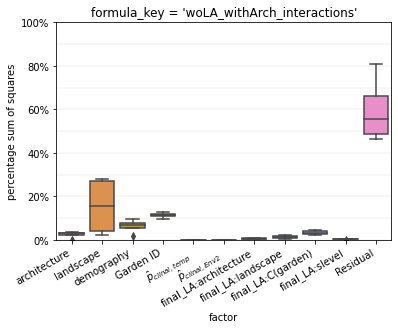

,architecture,landscape,demography,Garden ID,"$\^p_{clinal, temp}$","$\^p_{clinal, Env2}$",final_LA:architecture,final_LA:landscape,final_LA:C(garden),final_LA:slevel,Residual
RONA,0.09,1.98,1.92,11.23,0.01,0.00,0.16,0.17,3.60,0.09,80.76
lfmm2,3.60,4.48,9.58,12.86,0.00,0.00,0.64,2.19,4.68,0.47,61.51
GF,3.21,27.99,6.81,11.12,0.06,0.03,0.52,0.77,2.67,0.37,46.46
rda,2.89,26.47,6.63,9.49,0.12,0.02,0.63,1.62,2.40,0.39,49.34


,factor,program,perc
0,architecture,RONA,0.09
1,architecture,lfmm2,3.60
2,architecture,GF,3.21
3,architecture,rda,2.89
4,landscape,RONA,1.98
5,landscape,lfmm2,4.48
6,landscape,GF,27.99
7,landscape,rda,26.47
8,demography,RONA,1.92
9,demography,lfmm2,9.58


In [29]:
formula_key = 'woLA_withArch_interactions'

print(ColorText(f'percentage sum of squares ({formula_key} factors)').bold())
print(ColorText(formulas[formula_key]).blue())
print('architecture = glevel + plevel + pleio + slevel')

df = create_perc_boxplot(formula_key)

df

<a id='vis'></a>
# 4. visualize rank of sum of squares
[top](#home)

In [30]:
def show_slope_graph(formula_key):
    """Create a slope graph, """
#     programs = [sums.name for sums in sos[formula_key]]
    colors = [(mvp.boxplot_kwargs['palette'][program], ) for program in programs]  # ( , ) create tuple with comma

    ax = slope_graph(*sos[formula_key],
                     labels=programs,
                     colors=colors,
                     figsize=(7, 8),
                     ascending=False,
                     all_yticks=True
                    )

#     ax.spines[:].set_visible(False)
    ax.set_ylabel('factor rank by sum of squares (first is greatest)\n')
    plt.title(f'{formula_key = }')

    plt.show()

    pass

super_simple


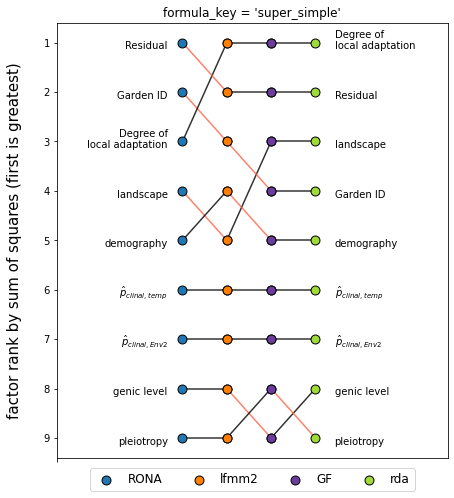




super_simple_interactions


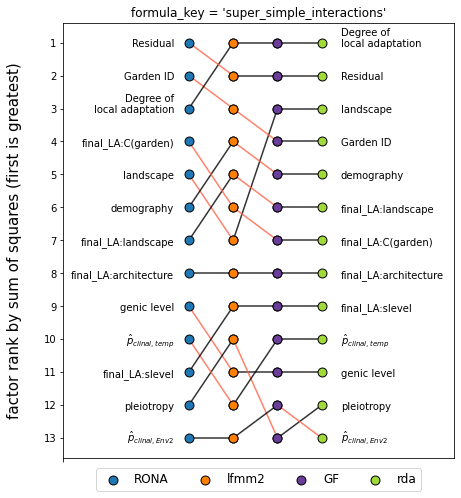




simple


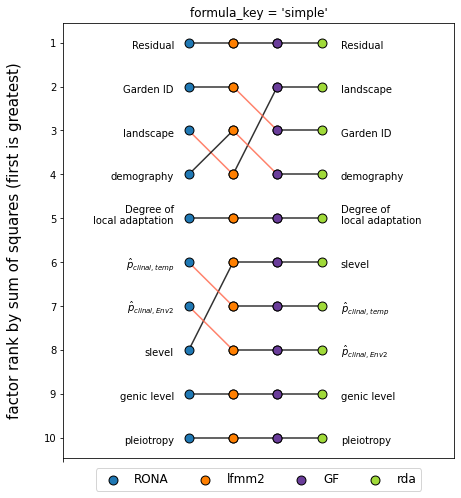




simple_interactions


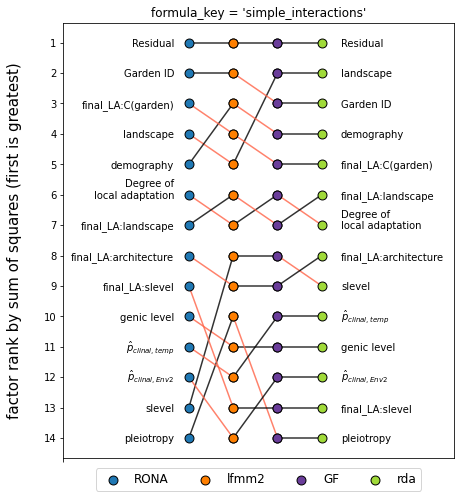




combined


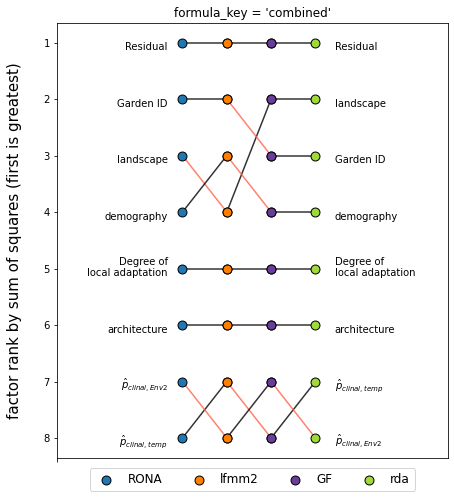




combined_interactions


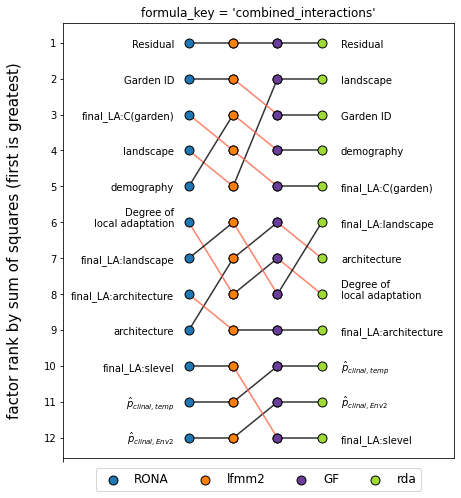




withLA_woArch


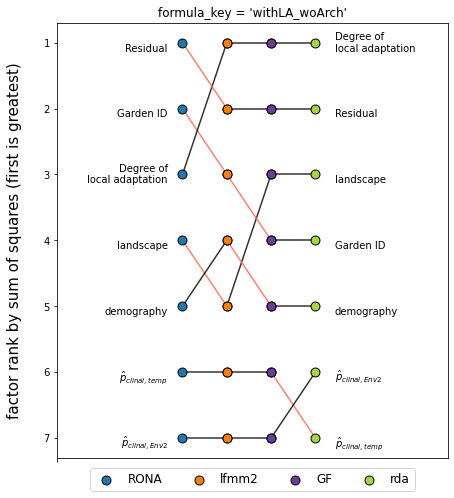




withLA_woArch_interactions


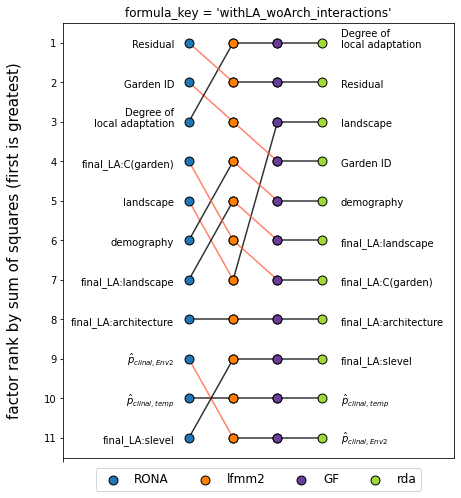




woLA_withArch


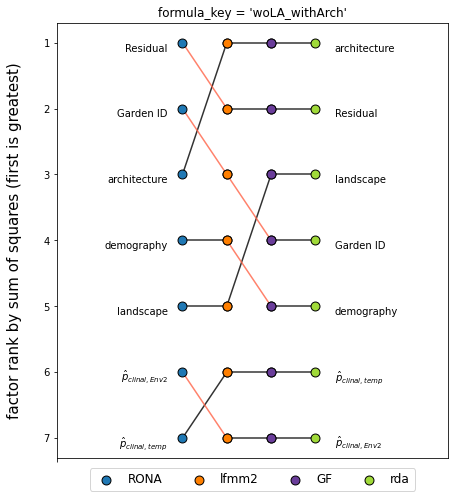




woLA_withArch_interactions


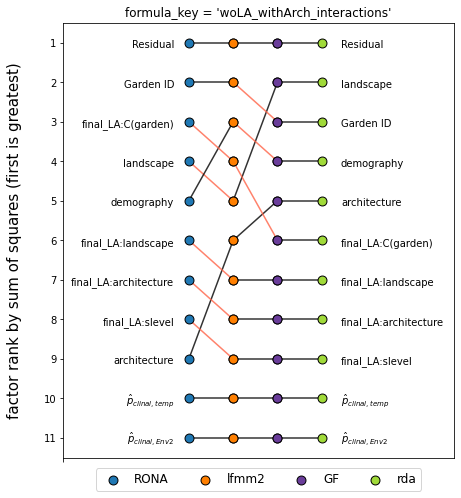

In [31]:
for formula_key in keys(sos):
    print(ColorText(formula_key).bold())
    show_slope_graph(formula_key)
    print('\n\n')

# make landscape fig

In [32]:
# combine program dataframes into one df
dfs = []
for program, df in bcs.items():
    df = df.copy()
    
    df['program'] = program
    
    dfs.append(df)

bcs_df = pd.concat(dfs)

bcs_df.head()

,garden,score,glevel,plevel,pleio,slevel,landscape,popsize,migration,marker_set,seed,simulation_level,env,offset_level,architecture,plevel_pleio,demography,seed_garden,final_LA,cor_TPR_temp,cor_TPR_sal,rep,simulation_garden,program,ntraits,noncausal_env,structcrxn
1231109,1,-0.334949,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,all,1231109,highly-polygenic_2-trait_no-pleiotropy_equal-S...,sal_opt,highly-polygenic_2-trait_no-pleiotropy_equal-S...,highly-polygenic_2-trait_no-pleiotropy_equal-S,2-trait_no pleiotropy,N-cline-center-to-edge_m-constant,1_1231109,0.501332,0.495283,0.013652,0-225,highly-polygenic_2-trait_no-pleiotropy_equal-S...,RONA,NaN,NaN,NaN
1231109,2,-0.244444,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,all,1231109,highly-polygenic_2-trait_no-pleiotropy_equal-S...,sal_opt,highly-polygenic_2-trait_no-pleiotropy_equal-S...,highly-polygenic_2-trait_no-pleiotropy_equal-S,2-trait_no pleiotropy,N-cline-center-to-edge_m-constant,2_1231109,0.501332,0.495283,0.013652,0-225,highly-polygenic_2-trait_no-pleiotropy_equal-S...,RONA,NaN,NaN,NaN
1231109,3,-0.165253,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,all,1231109,highly-polygenic_2-trait_no-pleiotropy_equal-S...,sal_opt,highly-polygenic_2-trait_no-pleiotropy_equal-S...,highly-polygenic_2-trait_no-pleiotropy_equal-S,2-trait_no pleiotropy,N-cline-center-to-edge_m-constant,3_1231109,0.501332,0.495283,0.013652,0-225,highly-polygenic_2-trait_no-pleiotropy_equal-S...,RONA,NaN,NaN,NaN
1231109,4,-0.099394,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,all,1231109,highly-polygenic_2-trait_no-pleiotropy_equal-S...,sal_opt,highly-polygenic_2-trait_no-pleiotropy_equal-S...,highly-polygenic_2-trait_no-pleiotropy_equal-S,2-trait_no pleiotropy,N-cline-center-to-edge_m-constant,4_1231109,0.501332,0.495283,0.013652,0-225,highly-polygenic_2-trait_no-pleiotropy_equal-S...,RONA,NaN,NaN,NaN
1231109,5,-0.086465,highly-polygenic,2-trait,no pleiotropy,equal-S,Est-Clines,N-cline-center-to-edge,m-constant,all,1231109,highly-polygenic_2-trait_no-pleiotropy_equal-S...,sal_opt,highly-polygenic_2-trait_no-pleiotropy_equal-S...,highly-polygenic_2-trait_no-pleiotropy_equal-S,2-trait_no pleiotropy,N-cline-center-to-edge_m-constant,5_1231109,0.501332,0.495283,0.013652,0-225,highly-polygenic_2-trait_no-pleiotropy_equal-S...,RONA,NaN,NaN,NaN


In [39]:
def cleanup_fig(g, xlabel="Landscape"):
    """Make the fig look rull pretty."""
    adjust_box_widths(list(g.axes[0]), 0.85)
    g.set(ylim=(0.65, -1),
          yticks=mvp.ytick_labels,
          yticklabels=mvp.ytick_labels)
    g.set_axis_labels(xlabel, "Validation Score (Kendall's $\\tau$)", fontsize=12)
    plt.setp(g.legend.get_texts(), fontsize='14') 
    plt.setp(g.legend.get_title(), fontsize='14')
    g.legend.set_bbox_to_anchor((1.03, 0.6))
    mvp.jitter_fliers(g)
    
    g.tight_layout()
    
    pass
    

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/figs/landscape_by_method_performance.pdf


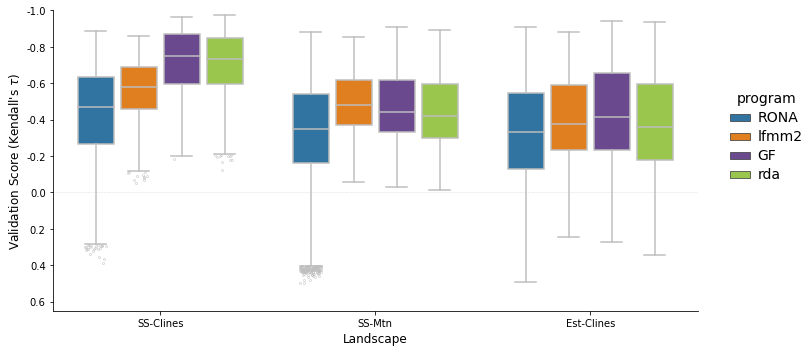

In [43]:
g = sns.catplot(data=bcs_df,
                x='landscape',
                y='score',
                order=['SS-Clines', 'SS-Mtn', 'Est-Clines'],
                hue='program',
                kind='box',
                height=5,
                aspect=2,
                **mvp.boxplot_kwargs
               )

cleanup_fig(g)

# line at tau = 0
for ax in g.axes[0]:
    ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)

save_pdf(op.join(figdir, 'landscape_by_method_performance.pdf'))

plt.show()

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/figs/method_by_landscape_performance.pdf


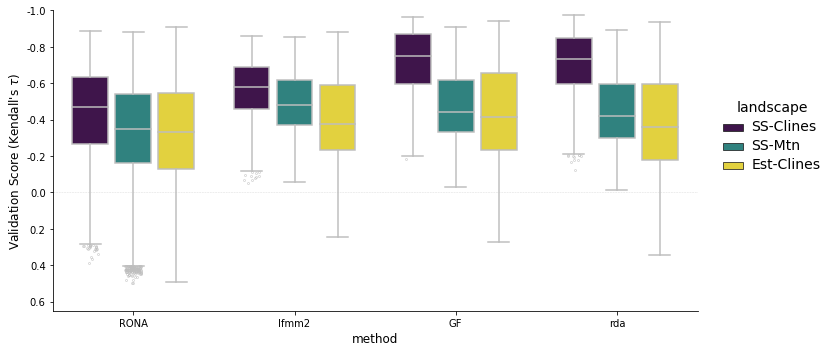

In [41]:
g = sns.catplot(data=bcs_df,
                x='program',
                y='score',
                hue='landscape',
                hue_order=['SS-Clines', 'SS-Mtn', 'Est-Clines'],
                kind='box',
                height=5,
                aspect=2,
                **mvp.boxplot_kwargs
               )

cleanup_fig(g, xlabel='method')

# line at tau = 0
for ax in g.axes[0]:
    ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)

save_pdf(op.join(figdir, 'method_by_landscape_performance.pdf'))

plt.show()

# make genic fig

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/figs/method_by_glevel_performance.pdf


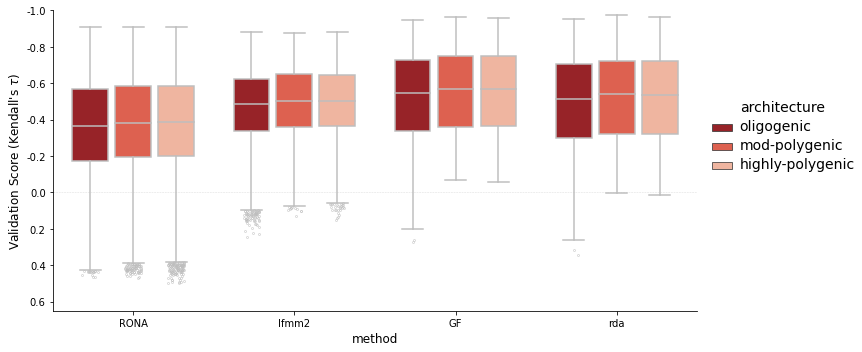

In [42]:
g = sns.catplot(data=bcs_df,
                x='program',
                y='score',
                hue='glevel',
                hue_order=['oligogenic', 'mod-polygenic', 'highly-polygenic'],
                kind='box',
                height=5,
                aspect=2,
                **mvp.boxplot_kwargs
               )

cleanup_fig(g, xlabel='method')

g._legend.set_title('architecture')

# line at tau = 0
for ax in g.axes[0]:
    ax.axhline(0, linestyle='--', color='gainsboro', linewidth=0.5, zorder=0)
    
save_pdf(op.join(figdir, 'method_by_glevel_performance.pdf'))

plt.show()

# save objects

In [37]:
for basename in ['lms', 'res', 'sos']:
    pkl = op.join(summarydir, f'{basename}.pkl')
    
    pkldump(globals()[basename], pkl)
    
    print(pkl)

/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/lms.pkl
/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/res.pkl
/work/lotterhos/MVP-Offsets/run_20220919/summaries/02_stats/01_Q1/sos.pkl


In [38]:
formatclock(dt.now() - t1)

'0-03:00:00'